<a href="https://colab.research.google.com/github/Bio-MingChen/DL_practice_by_Colab/blob/main/pytorch_test_20250806.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets,transforms
import torch.nn.functional as F

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [41]:
training_data = datasets.MNIST(root="data",train=True,download=True,transform=transforms.ToTensor())
test_data = datasets.MNIST(root="data",train=False,download=True,transform=transforms.ToTensor())
train_loader = DataLoader(training_data,batch_size=64,shuffle=True)
test_loader = DataLoader(test_data,batch_size=64,shuffle=True)
baches = len(train_loader)
size = len(training_data)
print(f"The size of training data is {size}",f"The size of test data is {len(test_data)}",f"The size of batch is {baches}",sep="\n")

The size of training data is 60000
The size of test data is 10000
The size of batch is 938


In [43]:

training_data[0][0].shape

torch.Size([1, 28, 28])

In [46]:
def conv2d_output_size(H_in,W_in,kernel_size,stride=1,padding=0,dilation=1):
  """
    计算 Conv2D 输出图像的尺寸

    参数：
        H_in, W_in: 输入图像的高和宽
        kernel_size: 卷积核大小（int 或 tuple）
        stride: 步长（int 或 tuple）
        padding: 填充（int 或 tuple）
        dilation: 膨胀（默认为 1）

    返回：
        H_out, W_out: 输出图像的高和宽
    """
  if isinstance(kernel_size, int):
    kernel_size = (kernel_size, kernel_size)
  if isinstance(stride, int):
    stride = (stride, stride)
  if isinstance(padding, int):
    padding = (padding, padding)
  if isinstance(dilation, int):
    dilation = (dilation, dilation)

  H_out = ((H_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) // stride[0]) + 1
  W_out = ((W_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) // stride[1]) + 1
  return H_out, W_out

def pool2d_output_size(H_in, W_in, kernel_size, stride=None, padding=0):
  """
  计算池化层（MaxPool2D）输出图像尺寸

  参数：
      H_in, W_in: 输入图像的高和宽
      kernel_size: 池化核大小（int 或 tuple）
      stride: 步长（int 或 tuple，默认等于 kernel_size）
      padding: 填充（int 或 tuple）

  返回：
      H_out, W_out: 输出图像的高和宽
  """
  if stride is None:
    stride = kernel_size
  if isinstance(kernel_size, int):
    kernel_size = (kernel_size, kernel_size)
  if isinstance(stride, int):
    stride = (stride, stride)
  if isinstance(padding, int):
    padding = (padding, padding)

  H_out = ((H_in + 2 * padding[0] - kernel_size[0]) // stride[0]) + 1
  W_out = ((W_in + 2 * padding[1] - kernel_size[1]) // stride[1]) + 1
  return H_out, W_out

class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.H, self.W = self._get_output_size()
    # encoder
    self.conv1 = nn.Conv2d(1,16,3,stride=1,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,stride=1,padding=1)
    self.maxpool = nn.MaxPool2d(2,stride=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(32 * self.H * self.W,128)
    self.fc21 = nn.Linear(128,20)
    self.fc22 = nn.Linear(128,20)
    self.bn1 = nn.BatchNorm2d(16)
    self.bn2 = nn.BatchNorm2d(32)
    # self.dropout1 = nn.Dropout(0.25)
    # self.dropout2 = nn.Dropout(0.5)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

    #decoder
    self.defc1 = nn.Linear(20,128)
    self.defc2 = nn.Linear(128,32* self.H * self.W)
    self.upconv = nn.ConvTranspose2d(32,32,2,stride=2) # 上采样 14x14 -> 28x28
    self.deconv1 = nn.Conv2d(32, 16, 3, stride=1, padding=1)
    self.deconv2 = nn.Conv2d(16, 1, 3, stride=1, padding=1)

  def _get_output_size(self):
    H, W = 28 , 28
    H, W = conv2d_output_size(H, W, 3, 1, 1)
    H, W = conv2d_output_size(H, W, 3, 1, 1)
    H, W = pool2d_output_size(H, W, 2, 2)
    print(f"最终图片大小：{H} x {W}")

    return H, W

  def encoder(self,x):
    x = self.bn1(self.conv1(x))
    x = self.relu(x)
    x = self.bn2(self.conv2(x))
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    # x = self.dropout1(x)
    x = self.fc1(x)
    x = self.relu(x)
    # x = self.dropout2(x)
    mu = self.fc21(x)
    logvar = self.fc22(x)

    return mu, logvar

  def reparameterize(self,mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return std * eps + mu

  def decoder(self,z):
    x = self.defc1(z)
    # x = self.relu(x)
    # x = self.dropout2(x)
    x = self.defc2(x)
    # x = self.relu(self.defc2(x))
    # x = self.dropout1(x)
    x = x.view(-1, 32, self.H, self.W)
    x = self.upconv(x)
    x = self.deconv1(x)
    # x = self.relu(self.deconv1(x))
    x = self.deconv2(x)
    # x = self.relu(self.deconv2(x))
    x = self.sigmoid(x)
    return x

  def forward(self,x):
    mu, logvar = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    recon_x = self.decoder(z)
    return recon_x, mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

最终图片大小：14 x 14


In [35]:
# https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 2, 2)

class VAE(nn.Module):
    def __init__(self, image_channels=1, z_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, 3, stride=2, padding=1),  # 28 → 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 14 → 7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 7 → 4
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 4 → 2
            nn.ReLU(),
            Flatten(),  # (B, 256*2*2 = 1024)
        )

        h_dim = 256 * 2 * 2
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            UnFlatten(),  # → (B, 256, 2, 2)
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 2→4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # 4→8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),    # 8→16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),     # 16→32
            nn.Sigmoid(),  # [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        return self.bottleneck(h)

    def decode(self, z):
        h = self.fc3(z)
        return self.decoder(h)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x[:, :, 2:30, 2:30], mu, logvar  # crop to 28x28

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [56]:
# recurrent code
from torchvision.transforms.functional import center_crop

class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(128, 256, 3, 2, 1),
        nn.ReLU(),
        nn.Flatten()
    )
    self.fc11 = nn.Linear(256 * 2 * 2, 20)
    self.fc12 = nn.Linear(256 * 2 * 2, 20)
    self.fc2 = nn.Linear(20, 256 * 2 * 2)

    self.decoder = nn.Sequential(
        nn.Unflatten(1, (256, 2, 2)),
        nn.ConvTranspose2d(256, 128, 4, 2, 1),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, 2, 1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, 4, 2, 1),
        nn.Sigmoid(),

    )

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + std * eps

  def bottleneck(self, h):
    mu = self.fc11(h)
    logvar = self.fc12(h)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

  def encode(self,x):
    h = self.encoder(x)
    # print(f"⚠️ encoder output shape: {h.shape}")
    z, mu, logvar = self.bottleneck(h)
    return z, mu, logvar

  def decode(self,z):
    z = self.fc2(z)
    recon_x = self.decoder(z)
    return recon_x

  def forward(self, x):
    z, mu, logvar = self.encode(x)
    recon_x = self.decode(z)
    recon_x = center_crop(recon_x, [28, 28])  # ✅ 修复方式
    return recon_x, mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 2, 2]         295,168
              ReLU-8            [-1, 256, 2, 2]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                   [-1, 20]          20,500
           Linear-11                   [-1, 20]          20,500
           Linear-12                 [-1, 1024]          21,504
        Unflatten-13            [-1, 256, 2, 2]               0
  ConvTranspose2d-14            [-1, 12

In [45]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
  BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE + beta * KLD

当然可以！KL 散度（Kullback-Leibler divergence，KL divergence）是变分自编码器（VAE）中的核心组成部分之一，用于衡量两个分布之间的差异。下面我会从直观解释、数学公式、在 VAE 中的具体计算方法三部分帮你彻底理解它：

---

## 🧠 一、KL 散度是啥？（直观理解）

KL 散度衡量的是：

> **“目标分布” 和 “参考分布” 之间有多远**，即：
> 如果你用参考分布 $Q(z)$ 来近似目标分布 $P(z)$，你要付出多大代价？

在 VAE 中：

* 真实但不可知的后验是：$p(z|x)$（不可求）
* 我们用一个可学习的近似后验 $q(z|x) \sim \mathcal{N}(\mu, \sigma^2)$
* 目标是让 $q(z|x)$ 尽可能贴近标准正态分布 $p(z) = \mathcal{N}(0, I)$

所以我们最小化：

$$
\text{KL}(q(z|x) \parallel p(z))
$$

---

## 🧮 二、KL 散度的数学公式（高斯之间）

KL 散度的通式是：

$$
\text{KL}(q \parallel p) = \int q(z) \log \frac{q(z)}{p(z)} \, dz
$$

但对于两个 **多维高斯分布**：

* $q(z|x) = \mathcal{N}(\mu, \sigma^2)$
* $p(z) = \mathcal{N}(0, 1)$

KL 有一个**解析解**（超重要）：

$$
\text{KL}(q(z|x) \parallel p(z)) = \frac{1}{2} \sum_{i=1}^{d} \left( \mu_i^2 + \sigma_i^2 - \log \sigma_i^2 - 1 \right)
$$

这里 $d$ 是 latent 维度，比如 20。

---

## 🔧 三、VAE 中的 KL 散度计算（PyTorch代码）

你在模型中输出了 `mu` 和 `logvar`，对应的是 $\mu$ 和 $\log \sigma^2$。

那么 KL loss 的实现通常如下：

```python
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
```

解释：

| 项目                               | 含义                                             |
| -------------------------------- | ---------------------------------------------- |
| `logvar`                         | $\log \sigma^2$，模型直接输出                         |
| `mu.pow(2)`                      | $\mu^2$                                        |
| `logvar.exp()`                   | $\sigma^2$                                     |
| `1 + logvar - mu² - exp(logvar)` | 就是解析式中的 $\sigma^2 + \mu^2 - \log \sigma^2 - 1$ |
| 总体乘上 `-0.5`                      | 得到最终 KL 值                                      |

---

## 🎯 四、在 VAE 的训练中，完整 Loss 这样写：

```python
def loss_function(recon_x, x, mu, logvar):
    # 重建误差（通常用 BCE 或 MSE）
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL 散度
    kl = kl_divergence(mu, logvar)
    
    return recon_loss + kl
```

---

## ✅ 总结表

| 项目                       | 内容                                                       |                                                              |
| ------------------------ | -------------------------------------------------------- | ------------------------------------------------------------ |
| KL 散度作用                  | 约束 latent space 分布靠近标准正态                                 |                                                              |
| 在 VAE 中的两个分布             | ( q(z                                                    | x) = \mathcal{N}(\mu, \sigma^2) )，$p(z) = \mathcal{N}(0, I)$ |
| KL 解析式                   | $\frac{1}{2} \sum (\mu^2 + \sigma^2 - \log\sigma^2 - 1)$ |                                                              |
| 代码实现                     | `-0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())`    |                                                              |
| 与 reconstruction loss 合用 | 形成 VAE 的总 loss，进行反向传播                                    |                                                              |

---

如果你感兴趣，我还可以讲讲：

* KL 散度和 mutual information 的关系
* β-VAE 是怎么改 KL 权重的
* 如何实现 annealing（KL warm-up）

你想了解哪一块？


In [13]:
import matplotlib.pyplot as plt

def comparison_plot(x, recon_x):
  n = min(x.size(0), 8)
  fig, ax = plt.subplots(2, n, figsize=(10,5))
  for i in range(n):
    ax[0, i].imshow(x[i].squeeze().cpu(), cmap="gray")
    ax[0, i].axis("off")

    ax[1, i].imshow(recon_x[i].squeeze().cpu(), cmap="gray")
    ax[1, i].axis("off")
  plt.tight_layout()
  plt.show()

def train(dataloader,model,loss_fn,optimizer,epoch):
  model.train()
  size = len(dataloader.dataset)
  train_loss = 0
  batches = len(dataloader)
  for batch, (X, _) in enumerate(dataloader):
    X = X.to(device)
    optimizer.zero_grad()
    recon_x, mu, logvar = model(X)
    beta = min(1.0, epoch / 10)
    loss = loss_fn(recon_x, X, mu, logvar, beta=beta)
    # loss = loss_fn(recon_x, X, mu, logvar)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch % 100 == 99:
      avg_loss = loss.item() / len(X)
      print(f"loss: {avg_loss:>7f}  [{batch * len(X):>5d}/{size:>5d}]")
  print(f"Epoch {epoch} train loss: {train_loss / size:.4f}")

def test(dataloader, model, loss_fn, epoch):
  model.eval()
  size = len(dataloader.dataset)
  batches = len(dataloader)
  test_loss = 0
  with torch.no_grad():
    for batch, (X, _) in enumerate(dataloader):
      X = X.to(device)
      recon_x, mu, logvar = model(X)
      loss = loss_fn(recon_x, X, mu, logvar)
      test_loss += loss.item()
      if batch == 0:
        comparison_plot(X, recon_x)
  avg_loss = test_loss / size
  print(f"Epoch {epoch} test loss: {avg_loss:.4f}")

Epoch 1
loss: 150.233627  [ 6336/60000]
loss: 121.755974  [12736/60000]
loss: 110.847664  [19136/60000]
loss: 108.188011  [25536/60000]
loss: 100.615128  [31936/60000]
loss: 103.770653  [38336/60000]
loss: 103.754395  [44736/60000]
loss: 93.379066  [51136/60000]
loss: 101.432487  [57536/60000]
Epoch 1 train loss: 117.4034


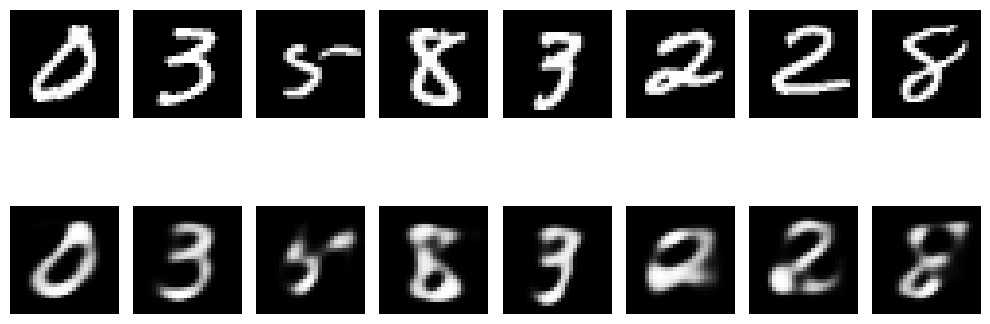

Epoch 1 test loss: 146.7876
Epoch 2
loss: 99.205215  [ 6336/60000]
loss: 95.474533  [12736/60000]
loss: 105.304688  [19136/60000]
loss: 95.111870  [25536/60000]
loss: 96.899628  [31936/60000]
loss: 98.471184  [38336/60000]
loss: 106.194412  [44736/60000]
loss: 98.174698  [51136/60000]
loss: 102.448555  [57536/60000]
Epoch 2 train loss: 99.6784


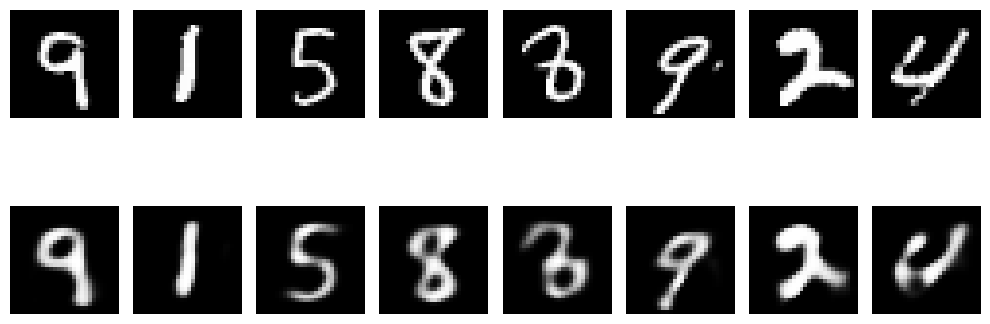

Epoch 2 test loss: 134.8104
Epoch 3
loss: 97.232185  [ 6336/60000]
loss: 103.255554  [12736/60000]
loss: 97.301895  [19136/60000]
loss: 99.322571  [25536/60000]
loss: 99.914726  [31936/60000]
loss: 99.046074  [38336/60000]
loss: 105.587914  [44736/60000]
loss: 97.978477  [51136/60000]
loss: 102.211304  [57536/60000]
Epoch 3 train loss: 102.2857


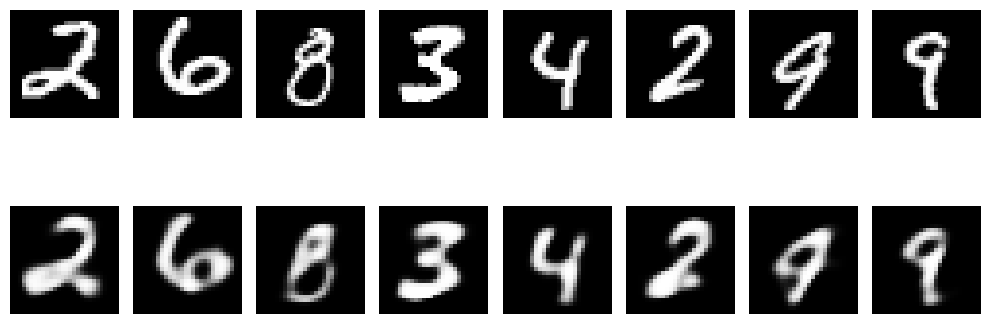

Epoch 3 test loss: 129.1088
Epoch 4
loss: 101.855492  [ 6336/60000]
loss: 112.102997  [12736/60000]
loss: 106.149071  [19136/60000]
loss: 109.019554  [25536/60000]
loss: 105.094193  [31936/60000]
loss: 104.955437  [38336/60000]
loss: 102.497612  [44736/60000]
loss: 105.714676  [51136/60000]
loss: 102.038330  [57536/60000]
Epoch 4 train loss: 104.0401


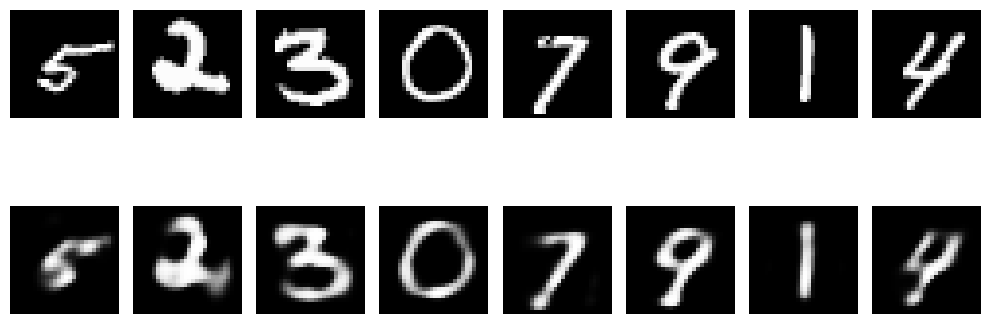

Epoch 4 test loss: 126.5518
Epoch 5
loss: 107.107025  [ 6336/60000]
loss: 108.338501  [12736/60000]
loss: 105.759964  [19136/60000]
loss: 109.189621  [25536/60000]
loss: 106.963074  [31936/60000]
loss: 108.227028  [38336/60000]
loss: 106.605515  [44736/60000]
loss: 107.885010  [51136/60000]
loss: 94.117477  [57536/60000]
Epoch 5 train loss: 107.3437


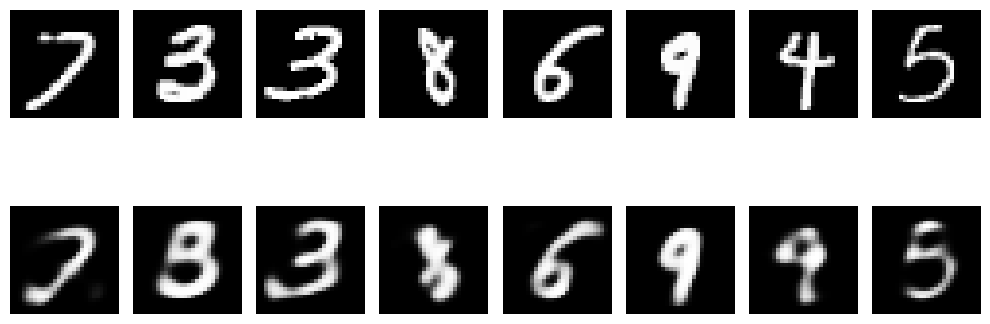

Epoch 5 test loss: 124.9741
Epoch 6
loss: 105.538597  [ 6336/60000]
loss: 108.104721  [12736/60000]
loss: 105.523125  [19136/60000]
loss: 110.205017  [25536/60000]
loss: 110.238564  [31936/60000]
loss: 109.552216  [38336/60000]
loss: 115.469193  [44736/60000]
loss: 105.354042  [51136/60000]
loss: 106.091255  [57536/60000]
Epoch 6 train loss: 110.6100


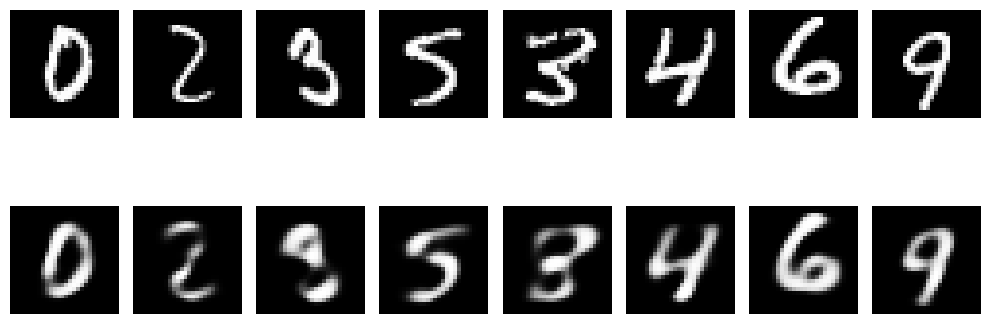

Epoch 6 test loss: 122.5957
Epoch 7
loss: 114.812546  [ 6336/60000]
loss: 121.516098  [12736/60000]
loss: 119.525757  [19136/60000]
loss: 114.547249  [25536/60000]
loss: 108.025490  [31936/60000]
loss: 109.143295  [38336/60000]
loss: 121.019417  [44736/60000]
loss: 113.401505  [51136/60000]
loss: 113.084511  [57536/60000]
Epoch 7 train loss: 113.6861


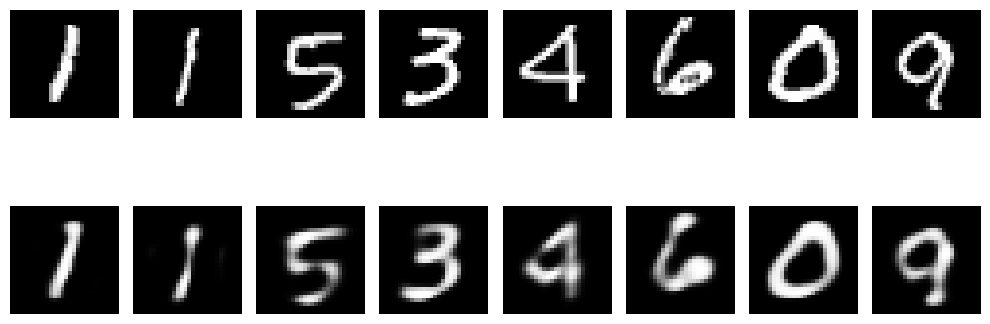

Epoch 7 test loss: 121.0484
Epoch 8
loss: 116.641769  [ 6336/60000]
loss: 116.026421  [12736/60000]
loss: 119.772751  [19136/60000]
loss: 119.790489  [25536/60000]
loss: 123.104172  [31936/60000]
loss: 123.417374  [38336/60000]
loss: 119.669617  [44736/60000]
loss: 113.373856  [51136/60000]
loss: 114.308701  [57536/60000]
Epoch 8 train loss: 116.5617


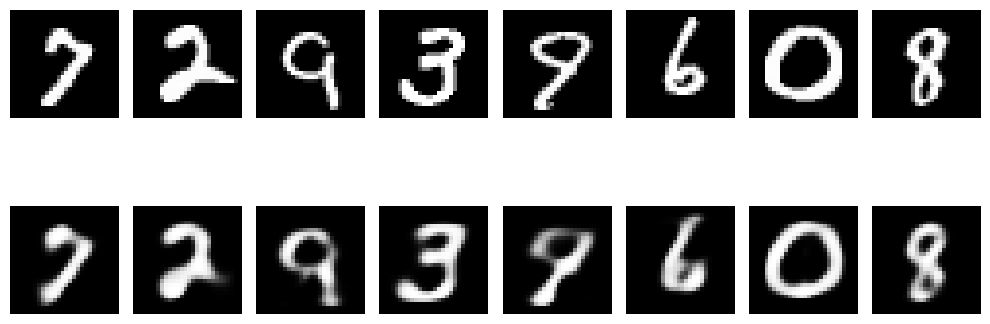

Epoch 8 test loss: 121.7776
Epoch 9
loss: 119.678169  [ 6336/60000]
loss: 117.044876  [12736/60000]
loss: 118.688866  [19136/60000]
loss: 117.877731  [25536/60000]
loss: 118.579163  [31936/60000]
loss: 116.755875  [38336/60000]
loss: 123.968422  [44736/60000]
loss: 127.103973  [51136/60000]
loss: 121.460358  [57536/60000]
Epoch 9 train loss: 119.4111


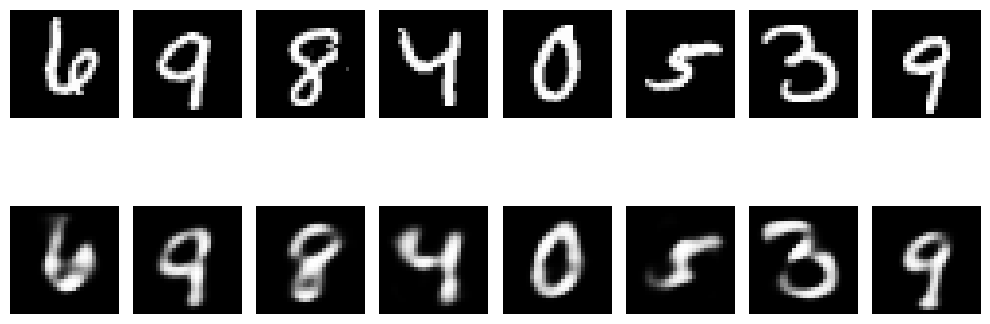

Epoch 9 test loss: 121.3532
Epoch 10
loss: 119.704468  [ 6336/60000]
loss: 125.018814  [12736/60000]
loss: 120.047409  [19136/60000]
loss: 118.150055  [25536/60000]
loss: 125.546532  [31936/60000]
loss: 124.631622  [38336/60000]
loss: 128.003021  [44736/60000]
loss: 121.393433  [51136/60000]
loss: 117.023232  [57536/60000]
Epoch 10 train loss: 121.9724


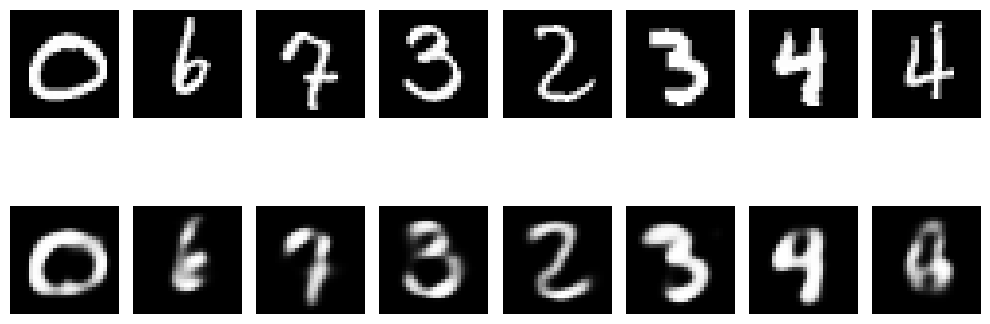

Epoch 10 test loss: 121.6183
Done


In [47]:
epochs = 10

for t in range(1, epochs+1):
  print(f"Epoch {t}\n =========================")
  train(train_loader,model,loss_function,optimizer,t)
  test(test_loader,model,loss_function,t)
print("Done")

Epoch 1
loss: 187.794907  [ 6336/60000]
loss: 135.172607  [12736/60000]
loss: 109.459213  [19136/60000]
loss: 98.737770  [25536/60000]
loss: 93.189125  [31936/60000]
loss: 89.721100  [38336/60000]
loss: 80.826355  [44736/60000]
loss: 79.827156  [51136/60000]
loss: 83.157967  [57536/60000]
Epoch 1 train loss: 119.2426


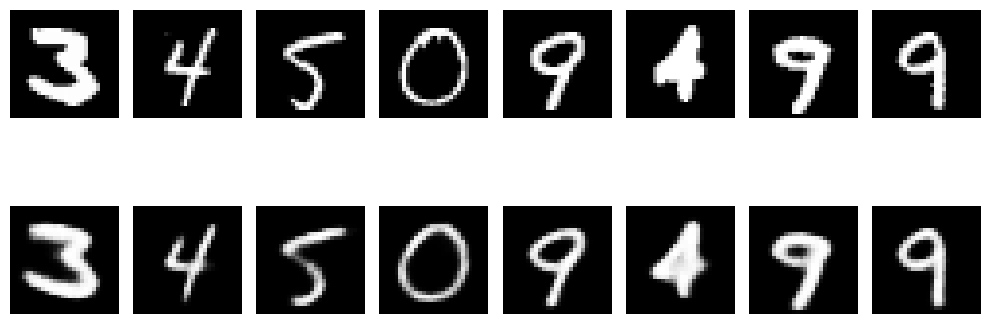

Epoch 1 test loss: 137.6220
Epoch 2
loss: 83.433678  [ 6336/60000]
loss: 78.541336  [12736/60000]
loss: 74.787285  [19136/60000]
loss: 84.036201  [25536/60000]
loss: 79.857002  [31936/60000]
loss: 80.607307  [38336/60000]
loss: 80.765907  [44736/60000]
loss: 73.452583  [51136/60000]
loss: 79.539337  [57536/60000]
Epoch 2 train loss: 81.2729


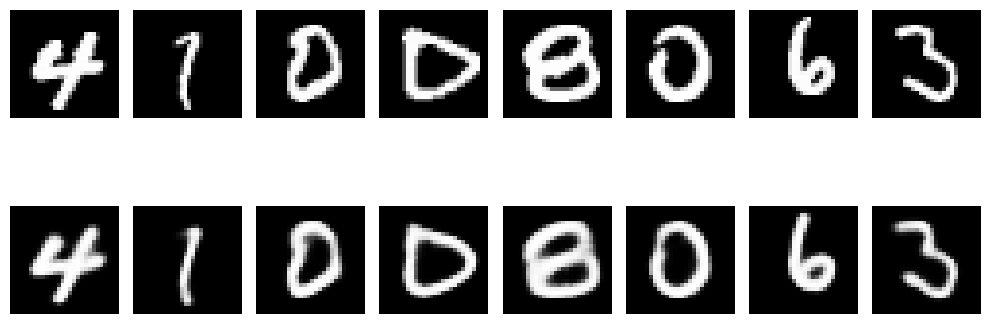

Epoch 2 test loss: 118.2887
Epoch 3
loss: 83.130913  [ 6336/60000]
loss: 83.475815  [12736/60000]
loss: 83.809227  [19136/60000]
loss: 80.921761  [25536/60000]
loss: 82.655022  [31936/60000]
loss: 79.870064  [38336/60000]
loss: 83.612946  [44736/60000]
loss: 79.840225  [51136/60000]
loss: 80.962990  [57536/60000]
Epoch 3 train loss: 81.7569


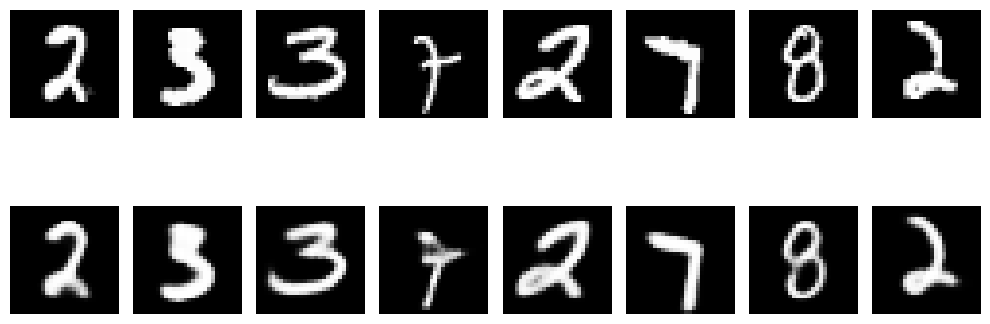

Epoch 3 test loss: 110.4562
Epoch 4
loss: 86.878365  [ 6336/60000]
loss: 85.851181  [12736/60000]
loss: 80.099503  [19136/60000]
loss: 84.587593  [25536/60000]
loss: 82.987617  [31936/60000]
loss: 81.455635  [38336/60000]
loss: 83.555191  [44736/60000]
loss: 79.638428  [51136/60000]
loss: 82.299515  [57536/60000]
Epoch 4 train loss: 84.1273


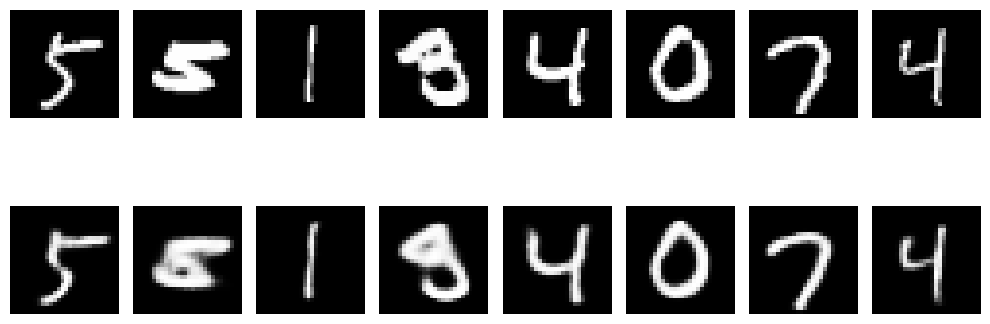

Epoch 4 test loss: 107.0977
Epoch 5
loss: 87.581886  [ 6336/60000]
loss: 85.000732  [12736/60000]
loss: 83.083702  [19136/60000]
loss: 87.361282  [25536/60000]
loss: 86.334343  [31936/60000]
loss: 87.713104  [38336/60000]
loss: 84.615463  [44736/60000]
loss: 83.017975  [51136/60000]
loss: 88.888954  [57536/60000]
Epoch 5 train loss: 86.9588


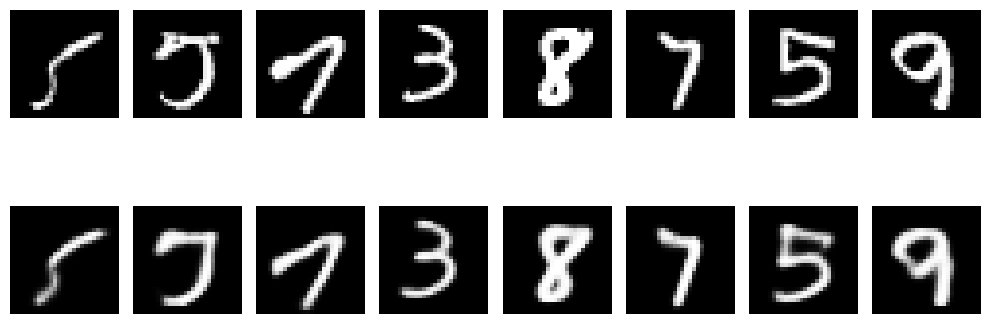

Epoch 5 test loss: 103.8148
Epoch 6
loss: 89.431190  [ 6336/60000]
loss: 88.416473  [12736/60000]
loss: 90.745453  [19136/60000]
loss: 92.630386  [25536/60000]
loss: 84.445663  [31936/60000]
loss: 85.421982  [38336/60000]
loss: 82.547020  [44736/60000]
loss: 87.899986  [51136/60000]
loss: 86.015350  [57536/60000]
Epoch 6 train loss: 89.5993


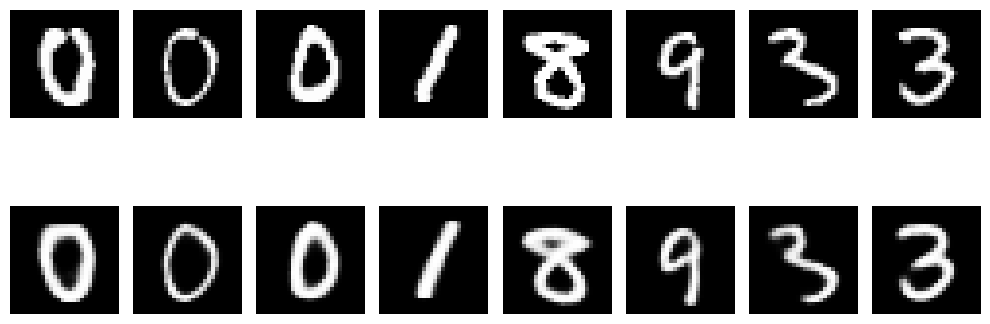

Epoch 6 test loss: 101.8082
Epoch 7
loss: 94.117165  [ 6336/60000]
loss: 96.225677  [12736/60000]
loss: 95.184235  [19136/60000]
loss: 92.271393  [25536/60000]
loss: 89.742416  [31936/60000]
loss: 90.170952  [38336/60000]
loss: 89.748489  [44736/60000]
loss: 89.506348  [51136/60000]
loss: 83.977829  [57536/60000]
Epoch 7 train loss: 92.1962


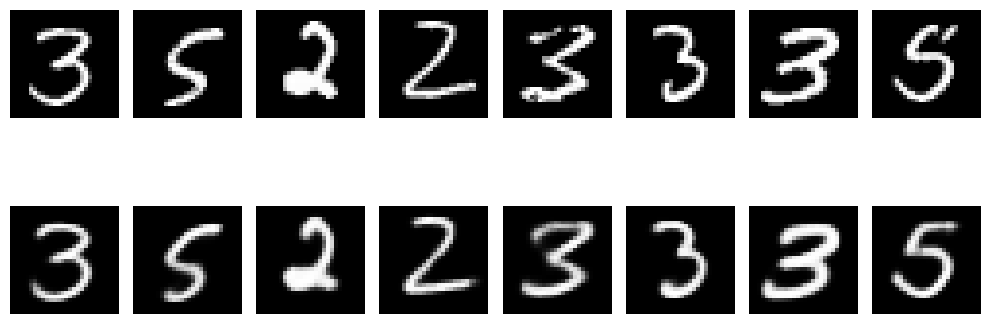

Epoch 7 test loss: 101.0347
Epoch 8
loss: 100.205460  [ 6336/60000]
loss: 97.618256  [12736/60000]
loss: 95.294525  [19136/60000]
loss: 95.805473  [25536/60000]
loss: 89.919991  [31936/60000]
loss: 95.843063  [38336/60000]
loss: 95.713326  [44736/60000]
loss: 95.199905  [51136/60000]
loss: 98.333893  [57536/60000]
Epoch 8 train loss: 94.6739


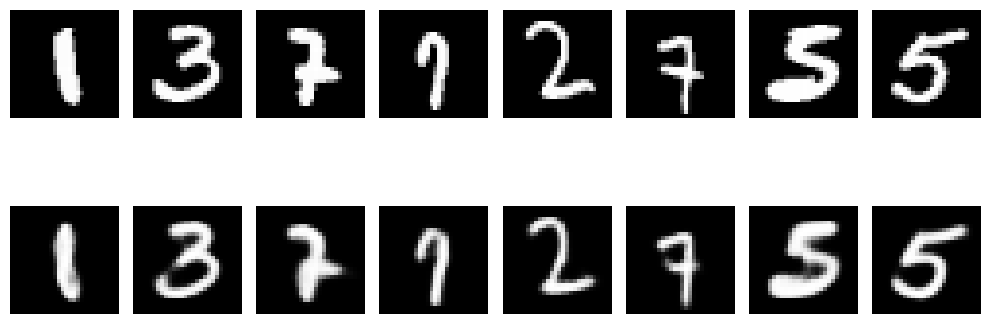

Epoch 8 test loss: 100.0420
Epoch 9
loss: 100.156616  [ 6336/60000]
loss: 93.483582  [12736/60000]
loss: 97.348305  [19136/60000]
loss: 95.683128  [25536/60000]
loss: 94.520744  [31936/60000]
loss: 99.634720  [38336/60000]
loss: 94.489380  [44736/60000]
loss: 96.920349  [51136/60000]
loss: 94.460197  [57536/60000]
Epoch 9 train loss: 96.8791


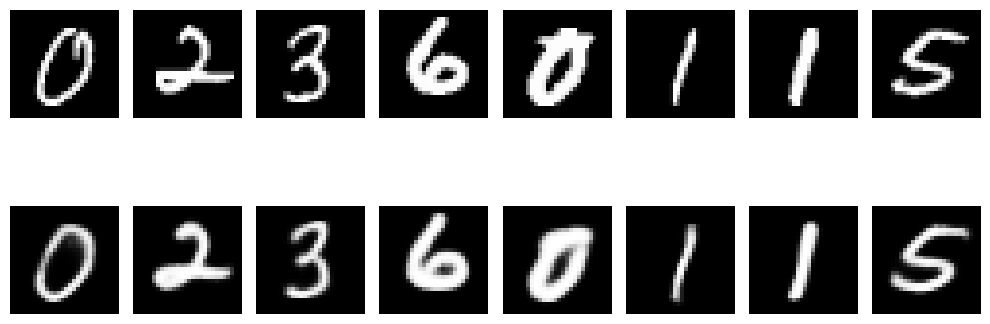

Epoch 9 test loss: 99.9171
Epoch 10
loss: 102.405106  [ 6336/60000]
loss: 98.022186  [12736/60000]
loss: 97.596260  [19136/60000]
loss: 103.012268  [25536/60000]
loss: 99.932472  [31936/60000]
loss: 97.946098  [38336/60000]
loss: 87.836517  [44736/60000]
loss: 99.149353  [51136/60000]
loss: 94.014061  [57536/60000]
Epoch 10 train loss: 99.1060


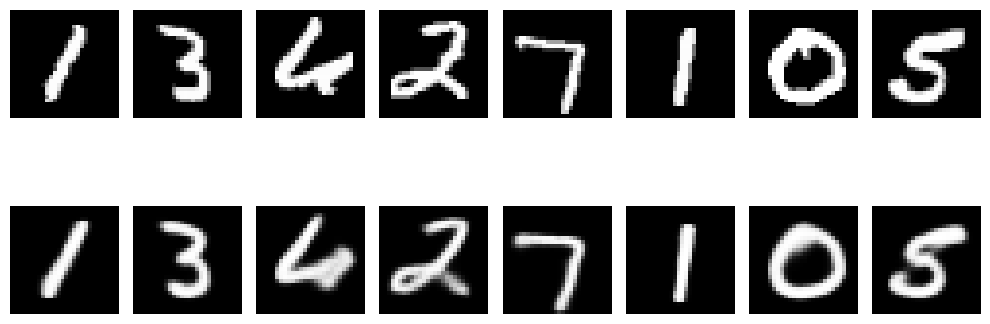

Epoch 10 test loss: 98.8422
Done


In [36]:
epochs = 10

for t in range(1, epochs+1):
  print(f"Epoch {t}\n =========================")
  train(train_loader,model,loss_function,optimizer,t)
  test(test_loader,model,loss_function,t)
print("Done")

Epoch 1
loss: 188.014465  [ 6336/60000]
loss: 144.756195  [12736/60000]
loss: 112.672829  [19136/60000]
loss: 104.354317  [25536/60000]
loss: 95.657898  [31936/60000]
loss: 86.429314  [38336/60000]
loss: 84.178253  [44736/60000]
loss: 81.570404  [51136/60000]
loss: 83.926376  [57536/60000]
Epoch 1 train loss: 119.5501


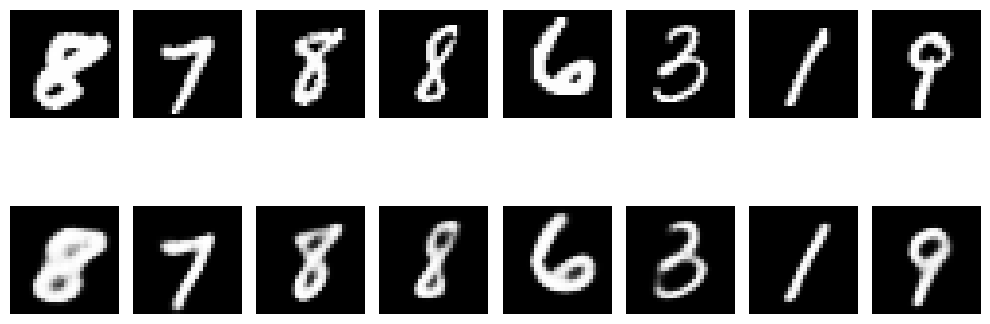

Epoch 1 test loss: 127.0146
Epoch 2
loss: 86.216446  [ 6336/60000]
loss: 87.124588  [12736/60000]
loss: 81.340248  [19136/60000]
loss: 77.195480  [25536/60000]
loss: 78.058693  [31936/60000]
loss: 76.689346  [38336/60000]
loss: 78.975159  [44736/60000]
loss: 77.179642  [51136/60000]
loss: 77.009575  [57536/60000]
Epoch 2 train loss: 80.5836


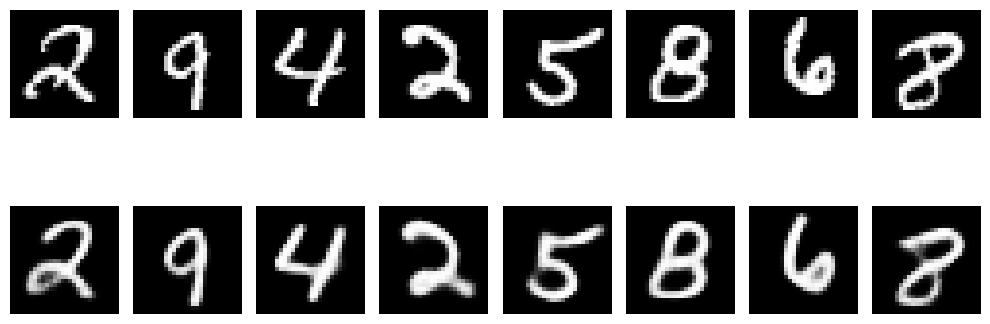

Epoch 2 test loss: 115.6291
Epoch 3
loss: 79.119080  [ 6336/60000]
loss: 81.368126  [12736/60000]
loss: 80.475128  [19136/60000]
loss: 85.089516  [25536/60000]
loss: 82.169968  [31936/60000]
loss: 81.519890  [38336/60000]
loss: 85.891975  [44736/60000]
loss: 84.779396  [51136/60000]
loss: 84.984589  [57536/60000]
Epoch 3 train loss: 81.8224


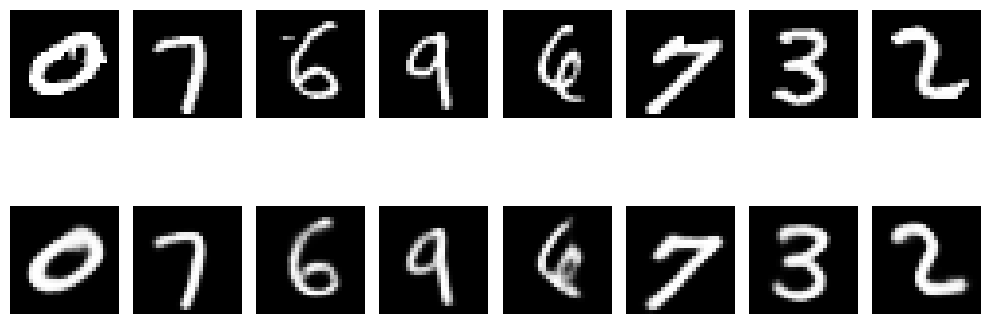

Epoch 3 test loss: 108.6225
Epoch 4
loss: 86.810371  [ 6336/60000]
loss: 81.492157  [12736/60000]
loss: 83.945023  [19136/60000]
loss: 82.855263  [25536/60000]
loss: 84.845078  [31936/60000]
loss: 83.308731  [38336/60000]
loss: 82.231842  [44736/60000]
loss: 83.305794  [51136/60000]
loss: 81.105019  [57536/60000]
Epoch 4 train loss: 84.3773


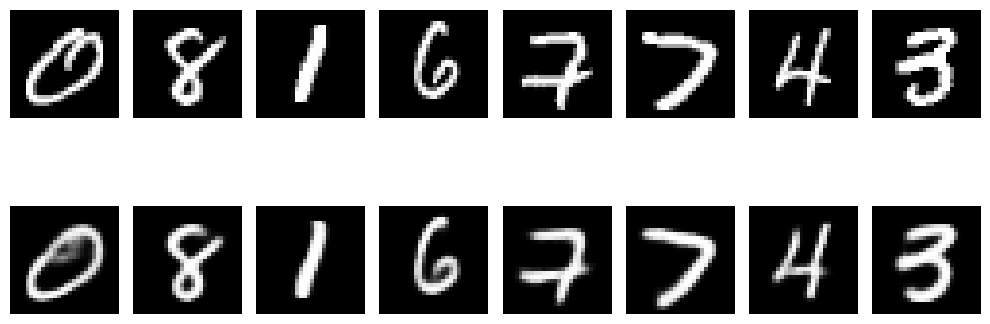

Epoch 4 test loss: 105.8857
Epoch 5
loss: 84.001701  [ 6336/60000]
loss: 85.867508  [12736/60000]
loss: 80.546265  [19136/60000]
loss: 84.261536  [25536/60000]
loss: 87.204865  [31936/60000]
loss: 85.186691  [38336/60000]
loss: 85.724106  [44736/60000]
loss: 86.119614  [51136/60000]
loss: 83.385437  [57536/60000]
Epoch 5 train loss: 87.0649


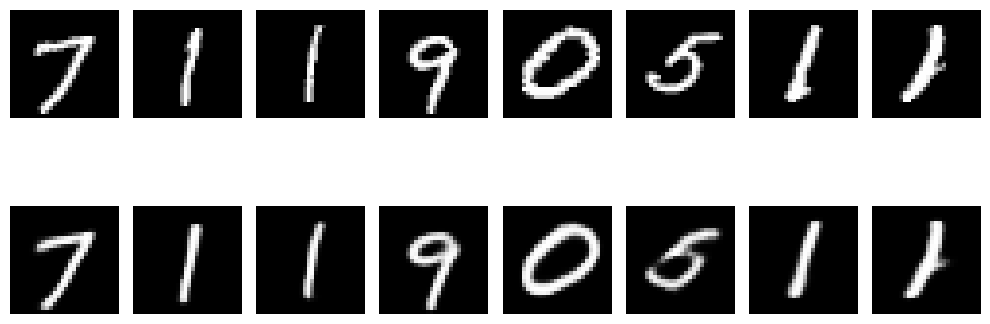

Epoch 5 test loss: 103.8739
Epoch 6
loss: 89.617447  [ 6336/60000]
loss: 91.950394  [12736/60000]
loss: 85.291672  [19136/60000]
loss: 87.941704  [25536/60000]
loss: 86.354103  [31936/60000]
loss: 87.311226  [38336/60000]
loss: 91.103111  [44736/60000]
loss: 91.249115  [51136/60000]
loss: 90.912842  [57536/60000]
Epoch 6 train loss: 89.5879


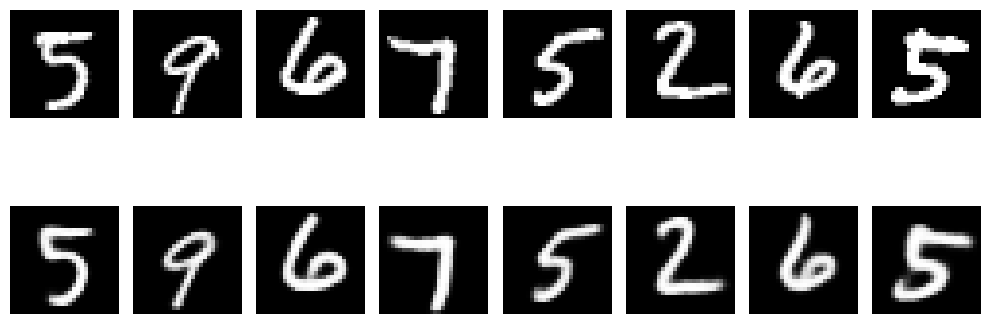

Epoch 6 test loss: 101.0737
Epoch 7
loss: 87.864220  [ 6336/60000]
loss: 91.143280  [12736/60000]
loss: 90.724899  [19136/60000]
loss: 89.614830  [25536/60000]
loss: 92.205444  [31936/60000]
loss: 89.002991  [38336/60000]
loss: 94.981056  [44736/60000]
loss: 88.478798  [51136/60000]
loss: 93.257759  [57536/60000]
Epoch 7 train loss: 91.9711


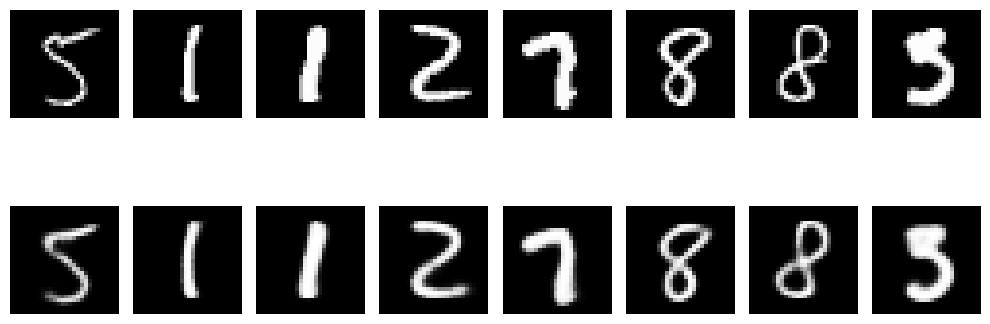

Epoch 7 test loss: 100.5025
Epoch 8
loss: 91.820648  [ 6336/60000]
loss: 92.174316  [12736/60000]
loss: 97.711067  [19136/60000]
loss: 95.096642  [25536/60000]
loss: 95.813782  [31936/60000]
loss: 94.984169  [38336/60000]
loss: 95.408638  [44736/60000]
loss: 91.996185  [51136/60000]
loss: 99.045258  [57536/60000]
Epoch 8 train loss: 94.3104


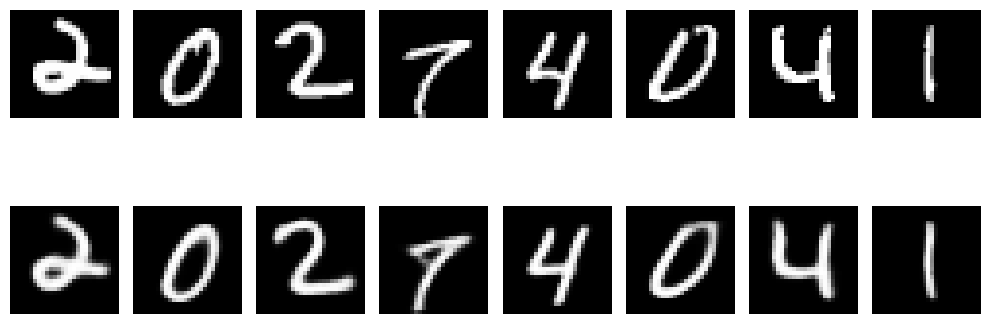

Epoch 8 test loss: 98.9966
Epoch 9
loss: 100.197784  [ 6336/60000]
loss: 101.108116  [12736/60000]
loss: 92.286880  [19136/60000]
loss: 99.169899  [25536/60000]
loss: 93.566246  [31936/60000]
loss: 98.884216  [38336/60000]
loss: 96.062561  [44736/60000]
loss: 97.326874  [51136/60000]
loss: 98.507553  [57536/60000]
Epoch 9 train loss: 96.5016


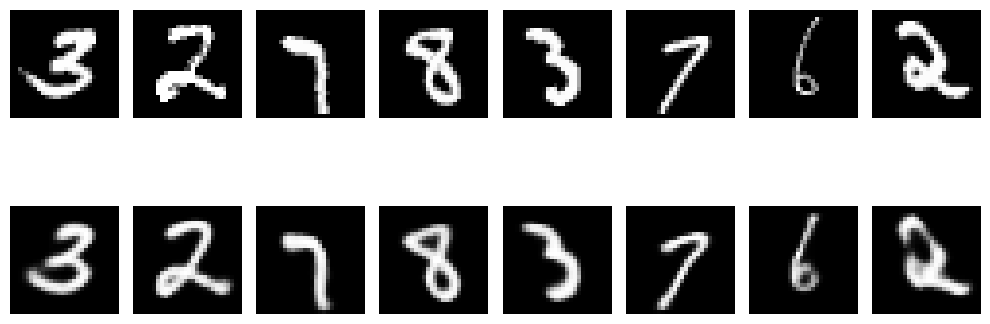

Epoch 9 test loss: 98.8528
Epoch 10
loss: 98.098419  [ 6336/60000]
loss: 102.241325  [12736/60000]
loss: 101.961052  [19136/60000]
loss: 100.043739  [25536/60000]
loss: 97.612846  [31936/60000]
loss: 98.813690  [38336/60000]
loss: 98.754845  [44736/60000]
loss: 93.195633  [51136/60000]
loss: 101.712204  [57536/60000]
Epoch 10 train loss: 98.6191


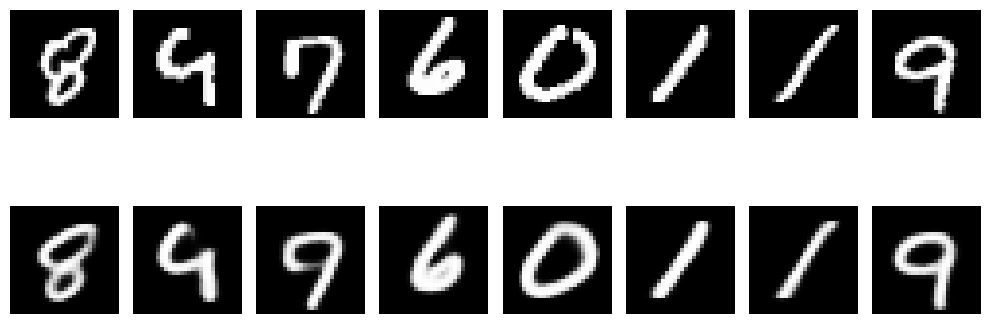

Epoch 10 test loss: 98.3938
Done


In [57]:
# recurrent code
epochs = 10

for t in range(1, epochs+1):
  print(f"Epoch {t}\n =========================")
  train(train_loader,model,loss_function,optimizer,t)
  test(test_loader,model,loss_function,t)
print("Done")

是的，现在这两个类（`Flatten` 和 `UnFlatten`）在 PyTorch 中都 **已经可以用内置的标准函数替代**，不需要手动定义。

---

## ✅ 1. 替代 `Flatten`

你可以使用：

```python
nn.Flatten()
```

等价于你自己写的：

```python
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
```

---

## ✅ 2. 替代 `UnFlatten`

如果你知道目标形状（如 `(256, 2, 2)`），可以用：

```python
nn.Unflatten(dim=1, unflattened_size=(256, 2, 2))
```

等价于：

```python
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 2, 2)
```

---

## ✅ 示例替换代码：

原来：

```python
self.decoder = nn.Sequential(
    UnFlatten(),
    nn.ConvTranspose2d(256, 128, 4, 2, 1),
    ...
)
```

替换为：

```python
self.decoder = nn.Sequential(
    nn.Unflatten(1, (256, 2, 2)),
    nn.ConvTranspose2d(256, 128, 4, 2, 1),
    ...
)
```

---

## 💡 补充建议：

你也可以动态记录编码后的形状，如：

```python
self.h_dim = 256 * 2 * 2  # 用于 Linear 的 in_features
```

---

## ✅ 总结

| 自定义类        | 替代写法                                              |
| ----------- | ------------------------------------------------- |
| `Flatten`   | `nn.Flatten()`                                    |
| `UnFlatten` | `nn.Unflatten(dim=1, unflattened_size=(C, H, W))` |

使用这些内置模块可以让代码更简洁、更标准化，也方便导出为 ONNX 等格式。

是否需要我帮你把整个模型结构做一次标准化替换？


In [24]:
def compute_conv_output_size(H_in, W_in, conv_layers):
    """
    打印并返回多层卷积后的图像尺寸。

    参数:
        H_in, W_in (int): 输入图像的高和宽
        conv_layers (list of tuples): 每层卷积的参数，格式如下：
            [(in_channels, out_channels, kernel_size, stride, padding), ...]

    返回:
        H_out, W_out (int): 最后一层的图像高和宽
    """

    def calc_out(H, W, kernel_size, stride, padding, dilation=1):
        H_out = ((H + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1
        W_out = ((W + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1
        return H_out, W_out

    print(f"Input size: {H_in} x {W_in}")
    for i, (in_c, out_c, k, s, p) in enumerate(conv_layers):
        H_in, W_in = calc_out(H_in, W_in, k, s, p)
        print(f"After Conv Layer {i+1}: Channels={out_c}, Size={H_in} x {W_in}")

    return H_in, W_in

H, W = 28, 28
conv_layers = [
    (1, 32, 4, 2, 1),
    (32, 64, 4, 2, 1),
    (64, 128, 4, 2, 1),
    (128, 256, 4, 1, 1),
]

H_out, W_out = compute_conv_output_size(H, W, conv_layers)
print(f"Final output size: {H_out} x {W_out}")


Input size: 28 x 28
After Conv Layer 1: Channels=32, Size=14 x 14
After Conv Layer 2: Channels=64, Size=7 x 7
After Conv Layer 3: Channels=128, Size=3 x 3
After Conv Layer 4: Channels=256, Size=2 x 2
Final output size: 2 x 2


`nn.Unflatten(1, (256, 2, 2))` 是 PyTorch 中的一个模块，用来 **把一维的 tensor 恢复成多维张量（常用于解码器 decoder 中）**。

---

### 🔍 它的作用是：

将形如 `(batch_size, 1024)` 的张量 → 变成 `(batch_size, 256, 2, 2)` 的张量

---

### 📌 参数解释：

```python
nn.Unflatten(dim, unflattened_size)
```

* `dim=1`：表示对第 1 个维度（即原来的 feature 向量）进行 unflatten（不包括 batch 维度）。
* `unflattened_size=(256, 2, 2)`：表示要把这一维 reshape 成 `(256, 2, 2)`。

---

### 🧠 举个例子

```python
import torch
from torch import nn

x = torch.randn(64, 1024)  # 假设是一个 batch size 为 64，flatten 后的输出
unflatten = nn.Unflatten(1, (256, 2, 2))  # 把第 1 维 (1024) 还原成 (256, 2, 2)
x_unflat = unflatten(x)

print(x_unflat.shape)  # 输出：torch.Size([64, 256, 2, 2])
```

---

### ✅ 应用场景（你现在的 VAE decoder）：

通常在 VAE 的 decoder 中，你会先：

1. 用 `Linear(z_dim → 1024)` 得到一个展平向量；
2. 然后用 `nn.Unflatten(1, (256, 2, 2))` 把它还原成图像形状；
3. 然后再用 `ConvTranspose2d` 进行上采样。

---

### 🔁 对应的 flatten 是？

你可以在 encoder 中看到：

```python
nn.Flatten()  # 会把 (B, C, H, W) → (B, C×H×W)
```

而 decoder 中 `nn.Unflatten()` 刚好是它的逆操作。

---

如需，我也可以帮你封装一对 `Flatten/Unflatten` 模块用于 encoder/decoder 中配套使用。


In [32]:
def generate_vae_architecture(input_size=(28, 28), num_layers=4, in_channels=1, base_channels=32):
    """
    自动生成适配 VAE 的 encoder/decoder 参数结构。

    参数:
        input_size (tuple): 输入图像大小 (H, W)
        num_layers (int): 卷积层数量（encoder 和 decoder 都是对称的）
        in_channels (int): 输入图像通道数
        base_channels (int): 第一层卷积输出通道数（之后每层翻倍）

    返回:
        encoder_layers, decoder_layers, final_feature_shape
    """
    H, W = input_size
    encoder_layers = []
    decoder_layers = []
    channels = in_channels

    h, w = H, W
    for i in range(num_layers):
        out_channels = base_channels * (2 ** i)
        encoder_layers.append((channels, out_channels, 4, 2, 1))  # k=4, s=2, p=1

        # 计算输出尺寸
        h = (h + 2 * 1 - 1 * (4 - 1) - 1) // 2 + 1
        w = (w + 2 * 1 - 1 * (4 - 1) - 1) // 2 + 1
        channels = out_channels

    # 编码后 flatten 的尺寸
    flatten_shape = (channels, h, w)
    h_fc = channels * h * w

    # decoder 的层参数
    decoder_channels = [base_channels * (2 ** i) for i in reversed(range(num_layers))]
    for i in range(num_layers):
        out_ch = decoder_channels[i+1] if i < num_layers - 1 else in_channels

        # decoder 每一层 ConvTranspose2d 参数
        decoder_layers.append((decoder_channels[i], out_ch, 4, 2, 1))

    return encoder_layers, decoder_layers, flatten_shape


In [33]:
enc, dec, shape = generate_vae_architecture(input_size=(28, 28), num_layers=4)

print("Encoder:")
for i, layer in enumerate(enc):
    print(f"Layer {i+1}: Conv2d({layer})")

print("\nDecoder:")
for i, layer in enumerate(dec):
    print(f"Layer {i+1}: ConvTranspose2d({layer})")

print("\nFlattened shape:", shape)


Encoder:
Layer 1: Conv2d((1, 32, 4, 2, 1))
Layer 2: Conv2d((32, 64, 4, 2, 1))
Layer 3: Conv2d((64, 128, 4, 2, 1))
Layer 4: Conv2d((128, 256, 4, 2, 1))

Decoder:
Layer 1: ConvTranspose2d((256, 128, 4, 2, 1))
Layer 2: ConvTranspose2d((128, 64, 4, 2, 1))
Layer 3: ConvTranspose2d((64, 32, 4, 2, 1))
Layer 4: ConvTranspose2d((32, 1, 4, 2, 1))

Flattened shape: (256, 1, 1)


好问题！你问的是关于 CNN 的输入、卷积核、输出通道数之间的关系，这对于深入理解 CNN 很关键。

我们来 **逐步剖析你的例子**：

---

## 🎯 问题复述

> 对于大小为 **`1×28×28`** 的图片，经过如下卷积操作：

```python
nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
```

你想问：

> 最终输出的“16个3×3的卷积核”是怎么来的？每一层到底发生了什么？下一层接收的到底是啥？

---

## ✅ 先搞清楚卷积层的各个参数含义

```python
nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
```

| 参数                | 含义                           |
| ----------------- | ---------------------------- |
| `in_channels=1`   | 输入图像有1个通道（灰度图）               |
| `out_channels=16` | 该卷积层有 16 个不同的卷积核（每个产生一个输出通道） |
| `kernel_size=3`   | 每个卷积核的尺寸为 3×3                |
| `stride=2`        | 每次卷积跨两格滑动                    |
| `padding=1`       | 在图像边缘补一圈 0，使尺寸不太快缩小          |

---

## 📐 输出尺寸怎么计算？

输出空间尺寸（高和宽）计算公式为：

$$
\text{OutputSize} = \left\lfloor \frac{\text{InputSize} + 2 \cdot \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

对于你的情况：

* 输入尺寸：`28 × 28`
* 计算输出尺寸：

  $$
  \left\lfloor \frac{28 + 2*1 - 3}{2} \right\rfloor + 1 = \left\lfloor \frac{27}{2} \right\rfloor + 1 = 13 + 1 = 14
  $$

🔹 所以输出尺寸是 `16 × 14 × 14`

---

## 🔍 每个卷积核到底是啥？

你写的：

> 得到了 16 个 3×3 的卷积核嘛？

其实是：

### ✅ 有 16 个**输出通道**，每个通道由一个**独立的卷积核组**生成：

* 因为你输入是 `in_channels=1`，所以：

  * 每个输出通道只需要一个 `3×3×1` 的卷积核
* 所以你有：

  * **16 个大小为 3×3 的卷积核**

结果是：

> 对输入图像的每个区域，用这 16 个不同的卷积核滑动扫一遍，分别得到一个 `14×14` 的特征图。共输出 `16 × 14 × 14` 的张量。

---

## 🧠 下一层接收的是什么？

下一层（例如 `Conv2d(16, 32, 3, 1, 1)`）接收的就是：

```python
(batch_size, 16, 14, 14)
```

即 16 个通道的特征图，每个是 14×14。

> 下一层的每个输出通道，会对应**16 个 3×3 卷积核**，每个分别作用于一个输入通道，然后结果相加，生成新的输出通道。

---

## 🔁 总结

| 你写的内容        | 实际含义                                 |
| ------------ | ------------------------------------ |
| “16个3x3的卷积核” | 是的：**每个输出通道对应一个 3×3 卷积核**（因为输入只有1通道） |
| 输出了啥？        | 输出为 `(batch_size, 16, 14, 14)` 的张量   |
| 传给下一层的是什么？   | 就是这 `16×14×14` 的特征图                  |
| 下一层如何处理？     | 每个输出通道对应 `in_channels` 个卷积核，卷积后再求和   |

---

## 👀 可视化一下你这个层：

```python
conv = nn.Conv2d(1, 16, 3, 2, 1)
x = torch.randn(1, 1, 28, 28)
y = conv(x)
print(y.shape)  # → torch.Size([1, 16, 14, 14])
```

如果你想看 **卷积核权重的 shape**：

```python
print(conv.weight.shape)
# → torch.Size([16, 1, 3, 3]) 说明有 16 个 3x3 的卷积核
```

---

如果你还想知道更深层的结构，比如第二层如何处理多通道、反卷积、BN 之后结构怎么变，我也可以继续帮你展开。是否要继续？


In [ ]:
# RNN code example
# https://github.com/pytorch/examples/blob/main/mnist_rnn/main.py

非常棒的问题！你已经准确观察到：这段代码将一个用于 MNIST 分类的标准神经网络模型，替换成了基于 **LSTM** 的版本，其实质是：

> ✅ **将图像当作时间序列来处理，而不是空间图像来卷积**。

---

## 🧠 一句话解释 LSTM 和 CNN 的本质区别：

| 模型类型          | 输入理解方式                        | 适合处理的任务               |
| ------------- | ----------------------------- | --------------------- |
| CNN (卷积神经网络)  | 把图像当作一个 2D 空间结构（高×宽）          | 图像分类、目标检测、分割          |
| LSTM (循环神经网络) | 把图像当作 28 个时间步的序列（每一步是 28 维向量） | 时间序列预测、自然语言处理、逐步变化的数据 |

在这段代码中，你把 **28×28 图像**理解为：

> 一段长度为 28 的时间序列，每个时间步是一个 28 维的向量（即每行像素）。

---

## 🔍 LSTM 模型结构解析

让我们拆解这段代码的关键部分：

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(input_size=28, hidden_size=64, batch_first=True)
        self.batchnorm = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 10)
```

### ✅ 1. `self.rnn = nn.LSTM(input_size=28, hidden_size=64)`

* 输入图像为 `(batch_size, 1, 28, 28)`
* reshape 成 `(batch_size, 28, 28)`，表示 **28 个时间步，每步是一个 28 维向量**
* LSTM 处理每一行作为一个时间步，并记住之前的状态
* 输出是 `(batch_size, 28, 64)`，每个时间步输出 64 维的隐藏状态

```python
input = input.reshape(-1, 28, 28)
output, hidden = self.rnn(input)
output = output[:, -1, :]  # 只取最后一个时间步的输出（即全局语义）
```

---

### ✅ 2. `BatchNorm1d`, `Dropout`, `fc1`, `fc2`

后续流程是标准的分类器结构：

```python
output = self.batchnorm(output)
output = self.dropout1(output)
output = F.relu(self.fc1(output))
output = self.dropout2(output)
output = self.fc2(output)
output = F.log_softmax(output, dim=1)
```

最后输出 `[batch_size, 10]`，表示 10 类的对数概率。

---

## 📊 图像 vs 序列理解方式比较（以MNIST为例）

| 模型结构 | 输入表示          | 特征提取方式           | 空间信息利用        |
| ---- | ------------- | ---------------- | ------------- |
| CNN  | `[1, 28, 28]` | 通过局部卷积核扫描提取空间特征  | 高效利用局部图像结构    |
| LSTM | `[28, 28]`    | 逐行输入，考虑行与行之间的上下文 | 不考虑列方向的局部空间结构 |

---

## 🧠 为什么用 LSTM 处理图像？

虽然不常规，但你可以将图像视为序列：

* 行扫描：每行像素是一步
* 或者列扫描也可以（只需 transpose）

适用于一些任务：

* **笔迹识别**（像素顺序重要）
* **时间序列图像**（如心电图）
* **视频帧序列的特征提取**

但在标准图像分类任务中，**CNN 通常更有效**，因为它更适合处理空间局部结构。

---

## ✅ 小结：LSTM 版本的核心变化

| 模块     | LSTM 模型                           | CNN 模型                     |
| ------ | --------------------------------- | -------------------------- |
| 输入处理   | 将图像 reshape 成序列 `(batch, 28, 28)` | 保持 2D `(batch, 1, 28, 28)` |
| 特征提取   | LSTM 逐步提取行间信息                     | 卷积提取局部空间特征                 |
| 全连接层输入 | 最后时间步的 hidden 状态                  | flatten 后所有特征图拼接           |
| 输出层    | `log_softmax` 分类                  | 同样                         |

---

## 🚀 想继续深入？

你可以尝试以下方向：

1. **双向 LSTM**：看看是否提升精度
2. **换方向**：用列当时间步（`transpose(1,2)`）
3. **比较 LSTM vs CNN 性能**：训练同样 epoch 对比精度
4. **可视化 LSTM 时间步输出**：分析哪些时间步有贡献

需要我帮你写代码做对比/可视化，也可以告诉我！


是的，你的直觉完全正确：

> 在实际的 RNN 使用中，**多层 RNN（stacked RNN）非常常见**，尤其是在自然语言处理（NLP）和序列建模任务中。

---

## ✅ 一层 RNN 和多层 RNN 的区别是什么？

### 🔹 1 层 RNN（单层）：

* 输入：序列，比如长度 T 的向量序列
* RNN 计算：一步一步处理，每一步只利用前一步的状态
* **只能建模浅层时间结构**

```python
self.rnn = nn.LSTM(input_size=28, hidden_size=64, batch_first=True)
```

此时输出 shape 是：

```
(batch_size, seq_len=28, hidden_size=64)
```

---

### 🔸 多层 RNN（深层）

你可以写成：

```python
self.rnn = nn.LSTM(input_size=28, hidden_size=64, num_layers=2, batch_first=True)
```

* `num_layers=2` 表示有 **两层 RNN 堆叠**
* 第 1 层的输出作为第 2 层的输入
* 每一层都有自己的权重、隐藏状态

---

## 🧠 为什么用多层 RNN？

| 用多层 RNN 的目的 | 解释                      |
| ----------- | ----------------------- |
| 捕捉更高阶的时间依赖  | 比如第一层捕捉局部信息，第二层聚合更长的上下文 |
| 更强的表达能力     | 类似于 CNN 中堆叠更多卷积层的效果     |
| 更容易建模复杂模式   | 尤其是 NLP 任务中的长句子、文档建模    |

---

## ✅ PyTorch 中使用多层 RNN 的方法

你可以直接设置 `num_layers > 1`，例如：

```python
self.rnn = nn.LSTM(input_size=28, hidden_size=64, num_layers=3, batch_first=True)
```

然后你依然只用最后一层的输出：

```python
output, (hn, cn) = self.rnn(input)  # hn shape: (num_layers, batch, hidden_size)
last_output = output[:, -1, :]      # shape: (batch, hidden_size)
```

---

## 📌 补充：可以用 `hn[-1]` 来直接取最后一层最后一个时间步的状态

```python
# hn shape: (num_layers, batch, hidden_size)
last_hidden = hn[-1]  # 取最后一层的输出
```

这个 `last_hidden` 就是多层 RNN 最深的输出。

---

## ✅ 实践建议

| 任务              | 建议的层数                                   |
| --------------- | --------------------------------------- |
| 简单分类任务（如 MNIST） | 1 层够用，避免过拟合                             |
| 序列建模 / NLP      | 2–3 层比较常见                               |
| 语音识别 / 视频理解     | 3–5 层或配合 CNN 使用                         |
| 模型太深            | 可能会梯度消失、训练不稳定，可考虑加 Residual、LayerNorm 等 |

---

## ✅ 总结

| 项目   | 一层 RNN            | 多层 RNN                |
| ---- | ----------------- | --------------------- |
| 表达能力 | 限制在局部时序           | 可以捕捉更复杂的时间依赖          |
| 使用方法 | 默认 `num_layers=1` | 设置 `num_layers=2` 或更多 |
| 输出   | 单层隐藏状态            | 每层都有状态，用最后一层输出        |
| 适用场景 | 简单任务              | NLP/语音/视频/时间序列建模等复杂任务 |

---

如果你愿意，我可以帮你把刚刚的代码改成 **双层 LSTM + Dropout + BatchNorm** 的版本，并解释各个细节。是否继续？


你的问题都非常有深度，下面我来逐个详解，帮助你从**原理 + 实践角度全面理解 RNN 的多层结构**：

---

## 🧠 一、RNN 多层之间是否需要 ReLU 或其他激活函数？

### ❗结论：

**不需要你手动加 ReLU、Tanh 等激活函数**，因为：

> ✅ **RNN/LSTM/GRU 本身内部就有非线性激活函数！**

### 具体说明：

| 模型类型      | 内部激活函数                      |
| --------- | --------------------------- |
| `nn.RNN`  | `tanh`（内部状态）+ `sigmoid`（门控） |
| `nn.LSTM` | `tanh` + `sigmoid`（控制门）     |
| `nn.GRU`  | `tanh` + `sigmoid`（更新门、重置门） |

所以，当你用 `num_layers=2` 时：

* PyTorch 自动堆叠两层 RNN/LSTM
* 第一层的输出会喂给第二层
* 中间已经有非线性激活了

👉 **不需要你再手动加 ReLU、Tanh，否则反而可能扰乱模型训练。**

---

## 📦 二、`batch_first=True` 是什么意思？

这个参数是 PyTorch 中处理输入维度顺序的重要标志。

### 🔹 默认行为（`batch_first=False`）：

输入形状为：

```python
(seq_len, batch_size, input_size)
```

比如：

```python
(28, 64, 28)
```

### ✅ 设置 `batch_first=True`：

输入变为：

```python
(batch_size, seq_len, input_size)
```

比如：

```python
(64, 28, 28)
```

这更符合我们常见的直觉（batch 在前），**所以推荐设为 `True`**，更好对接 `DataLoader`。

---

## 🔁 三、多层 RNN 的输出还是 `hidden_size=64` 吗？

是的！

即使是多层，只要你设置了：

```python
hidden_size = 64
num_layers = 2
```

那么：

* 每一层都会有 64 个隐藏单元
* **输出仍然是 64 维**，不过是第二层（最后一层）的输出

### 输出 shape：

```python
output, (hn, cn) = rnn(x)
```

| 变量       | shape                                   | 含义               |
| -------- | --------------------------------------- | ---------------- |
| `output` | `[batch_size, seq_len, hidden_size]`    | 所有时间步的输出（来自最后一层） |
| `hn`     | `[num_layers, batch_size, hidden_size]` | 每一层最后时间步的 hidden |
| `cn`     | 同上（LSTM 特有）                             | cell state       |

---

## 🎯 四、为啥常用 `hidden_size=64`？是经验值吗？

### ✅ 是的，这是一个**经验值 + 性能权衡点**：

| 数值               | 说明                         |
| ---------------- | -------------------------- |
| 32 / 64          | 模型小，计算快，适合入门和小数据集（如 MNIST） |
| 128 / 256        | 适合中等复杂度任务                  |
| 512 / 768 / 1024 | 用于大规模任务或语言模型（如 GPT）        |

使用较大的 `hidden_size` 会：

* 提升模型表达能力
* 同时增加参数量、显存占用、训练时间

---

## ✅ 小结表格

| 维度                  | 说明                                         |
| ------------------- | ------------------------------------------ |
| ReLU between layers | ❌ 不需要，RNN/LSTM内部自带激活函数                     |
| `batch_first=True`  | ✅ 输入为 `[batch, seq_len, input_size]`，更符合直觉 |
| 多层输出维度              | ✅ 输出仍是 `hidden_size`，即每层都是一样的宽度            |
| `hidden_size=64`    | ✅ 常见经验值，适合入门任务，如手写体识别等                     |

---

## 🔧 补充建议（进阶）：

如果你希望试试更强的模型结构，可以考虑：

* ✅ 使用 `nn.LSTM(..., num_layers=2, dropout=0.2)`

  * PyTorch 会自动在层之间添加 Dropout
* ✅ 使用双向 LSTM（`bidirectional=True`）

  * 输出维度会变成 `2×hidden_size`，因为有前向+后向

---

是否希望我用这些原则帮你升级刚才的 RNN 模型结构为「双层 + Dropout + 双向」版本，并讲解结构变化？


当然可以！下面我通过 **两个完整的小案例** 来对比说明：

---

## 🎯 目标

对比 RNN 在两种任务中的行为差异：

1. **语言模型任务**：每个时间步都要输出（比如预测下一个词）
2. **文本分类任务**：只取最后一个时间步的输出（比如情感分类）

---

## 🧪 案例一：语言建模（每个时间步都输出）

假设我们要训练一个模型来预测如下句子中**下一个词**：

```
Input:     I like deep
Target:       like deep learning
```

即：

* 输入序列：`["I", "like", "deep"]`
* 目标序列：`["like", "deep", "learning"]`

### ✅ RNN行为：

* 模型输入：`["I", "like", "deep"]`
* 模型输出：`[o1, o2, o3]`，每一个是对下一个词的预测
* `o1` → 预测 `"like"`，`o2` → 预测 `"deep"`，`o3` → 预测 `"learning"`

### ✅ PyTorch代码（伪代码）：

```python
output, _ = rnn(input_seq)  # output shape: (seq_len, batch, hidden_dim)
output = decoder(output)    # shape: (seq_len, batch, vocab_size)
loss = F.cross_entropy(output.view(-1, vocab_size), target_seq.view(-1))
```

> ✅ **每个时间步都贡献一个 loss**，训练目标是让每个输出都能预测下一个 token。

---

## 🧪 案例二：文本分类（只要最后一个输出）

假设我们要训练一个模型来判断句子情绪：

```
Input:     I like deep learning
Target:    positive
```

### ✅ RNN行为：

* 模型输入：句子序列
* 模型输出：一个向量（例如最后一个时间步的 hidden）
* 最后这个向量输入全连接层做分类（positive / negative）

### ✅ PyTorch代码（伪代码）：

```python
output, _ = rnn(input_seq)    # output shape: (seq_len, batch, hidden_dim)
final_output = output[-1]     # 取最后一个时间步
logits = decoder(final_output)
loss = F.cross_entropy(logits, label)
```

> ✅ 只有一个输出参与预测，训练目标是整体判断句子的情感。

---

## 🔍 对比总结表

| 特征     | 语言模型                             | 文本分类                 |
| ------ | -------------------------------- | -------------------- |
| 输入     | `[w1, w2, ..., wn-1]`            | `[w1, w2, ..., wn]`  |
| 输出     | `[o1, o2, ..., on-1]`（每一步预测下一个词） | `o_final`（一个向量）      |
| 使用哪个输出 | 所有时间步的输出                         | 最后时间步的输出             |
| loss计算 | `cross_entropy` 逐步预测             | `cross_entropy` 全局预测 |
| 应用场景   | GPT、生成模型、翻译                      | 情感分类、垃圾邮件识别          |

---

## 🧠 图示（你可以想象为）：

### 语言模型

```
Input:   I   like  deep
            ↓     ↓     ↓
Output: like deep learning
```

模型要学会：每个词后面最可能出现哪个词。

---

### 文本分类

```
Input:   I   like  deep  learning
                          ↓
                  (最后一个 time step 输出)
                          ↓
                 [positive / negative]
```

模型要学会：整句话情绪如何。

---

## 🔚 结论

> ✅ 语言模型：输出的是整个序列，每一时间步都监督
> ✅ 分类模型：只取最后一时刻的输出用于预测整个序列的标签

---

如果你想更深入了解“序列标注任务”（比如命名实体识别），它又是另一种“每步监督”的例子，我也可以举例说明。需要吗？


太好了！你现在进入了 RNN 的核心计算流程。我们来通过一个 **小例子**，**手工模拟**这段代码的行为，帮助你**从直觉上真正理解这个 forward+loss 的过程**。

---

## 🧪 场景：我们来做一个极简的语言模型任务

> 目标：给定一个词序列，预测下一个词。

---

### 🧠 词表（vocabulary）

假设我们的词表是这样的，`vocab_size = 5`：

| token      | index |
| ---------- | ----- |
| `<pad>`    | 0     |
| `I`        | 1     |
| `like`     | 2     |
| `deep`     | 3     |
| `learning` | 4     |

---

### 📥 输入序列 `input_seq`

假设我们有一句话：

```
"I like deep"
```

转为索引后就是：

```python
input_seq = [1, 2, 3]  # "I", "like", "deep"
target_seq = [2, 3, 4] #     "like", "deep", "learning"
```

这个训练样本的含义是：

| Time step | Input word | Target word |
| --------- | ---------- | ----------- |
| t=0       | "I"        | "like"      |
| t=1       | "like"     | "deep"      |
| t=2       | "deep"     | "learning"  |

---

## 🧠 模型结构简化回顾

我们模拟以下模型：

```python
embed = nn.Embedding(5, 8)       # vocab_size=5, embed_dim=8
rnn = nn.RNN(8, 16)              # embed_dim=8 → hidden_size=16
decoder = nn.Linear(16, 5)       # hidden_size=16 → vocab_size=5
```

---

## 🚀 一步一步地模拟 forward：

### 1. Embedding

将 input\_seq `[1, 2, 3]` 转换成向量：

```python
input_emb = embed(input_seq)
# 假设得到：(3, 1, 8)，即 seq_len=3, batch=1, embed_dim=8
```

---

### 2. RNN 编码

```python
output, _ = rnn(input_emb)
# output.shape = (3, 1, 16)  # 每个时间步输出一个 16 维向量
```

你可以理解为：

```text
output = [
  [h0],  ← 用于预测 "like"
  [h1],  ← 用于预测 "deep"
  [h2],  ← 用于预测 "learning"
]
```

---

### 3. Decoder 映射成词表上的概率

```python
decoded = decoder(output)
# decoded.shape = (3, 1, 5)  # 每个时间步都有一个 vocab_size=5 的预测分布
```

举个例子，假设输出为：

```python
decoded = [
  [[0.2, 2.1, 1.8, 0.3, 0.1]],  # 对应预测 "like"
  [[0.1, 0.2, 0.1, 2.0, 0.5]],  # 对应预测 "deep"
  [[0.2, 0.1, 0.3, 0.3, 2.4]]   # 对应预测 "learning"
]
```

---

### 4. Reshape + 计算 loss

```python
decoded = decoded.view(-1, vocab_size)  # shape: (3, 5)
target = torch.tensor([2, 3, 4])         # shape: (3,)
loss = F.cross_entropy(decoded, target)
```

| 时间步 | decoded logits              | target         |
| --- | --------------------------- | -------------- |
| t=0 | `[0.2, 2.1, 1.8, 0.3, 0.1]` | 2 ("like")     |
| t=1 | `[0.1, 0.2, 0.1, 2.0, 0.5]` | 3 ("deep")     |
| t=2 | `[0.2, 0.1, 0.3, 0.3, 2.4]` | 4 ("learning") |

每个时间步用 `cross_entropy` 算 loss，最终会求平均。

---

### ✅ 模拟的输出说明了：

> 🌟 每个时间步都被独立监督，用它的输出预测下一个词。

---

## 🔚 总结流程图

```
[1, 2, 3] ──> Embedding ──> RNN ──> Decoder ──> [3个向量] ──> CrossEntropy vs. [2, 3, 4]
      (I like deep)                                 (like, deep, learning)
```

---

## 💡 你应该记住的核心点：

| 步骤                      | 含义                                                                 |
| ----------------------- | ------------------------------------------------------------------ |
| `.view(-1, vocab_size)` | 将 `(seq_len, batch, vocab_size)` 展平成 `(seq_len*batch, vocab_size)` |
| 每步都有监督                  | 每个时间步都对应一个 target word                                             |
| 语言模型 loss               | 来自于每一步对“下一个词”的预测错误                                                 |
| RNN 输出用法                | 和分类任务不同，语言模型用“每一个时间步”的输出                                           |

---

是否需要我帮你用这套逻辑构造一个完整的 PyTorch 训练例子（用 toy 数据来训练）？可以亲自跑一遍体验这个过程。


这个问题问得非常好！

你已经在深入思考自然语言处理（NLP）中最核心的两个步骤了：
**tokenization（分词）** 和 **embedding（词嵌入）**。
它们是密切相关但**完全不同的两个阶段**。

---

## ✅ 一句话对比

| 概念                   | 作用                     | 举例                                                   |
| -------------------- | ---------------------- | ---------------------------------------------------- |
| **tokenization（分词）** | 把文本转成离散的 token（整数 ID）  | `"I like AI"` → `[1, 2, 3]`                          |
| **embedding（词嵌入）**   | 把离散的 token ID 映射成连续的向量 | `[1, 2, 3]` → `[[0.1, 0.2], [0.3, 0.5], [0.7, 0.9]]` |

---

## 🧩 举个完整例子

假设句子是：

```
"I like deep learning"
```

---

### ✅ 第一步：Tokenization（分词）

我们给词表分配整数 ID：

| Word       | Token ID |
| ---------- | -------- |
| `<pad>`    | 0        |
| `I`        | 1        |
| `like`     | 2        |
| `deep`     | 3        |
| `learning` | 4        |

Tokenization 过程结果是：

```python
["I", "like", "deep", "learning"] → [1, 2, 3, 4]
```

这一步本质上是 **离散化** + **数字化**。

---

### ✅ 第二步：Embedding（词嵌入）

你用的是 PyTorch 的：

```python
nn.Embedding(num_embeddings=5, embedding_dim=8)
```

意思是：把每个 token ID 映射成一个 8 维向量：

```python
[1, 2, 3, 4] → [
  [0.01, 0.23, ..., 0.12],  # I
  [0.91, 0.11, ..., 0.43],  # like
  [0.65, 0.04, ..., 0.23],  # deep
  [0.38, 0.59, ..., 0.19],  # learning
]
```

Embedding 层就是一个 **查表操作**（每个 token ID → 对应一行向量）。

---

## 📌 更深入地对比

| 方面    | Tokenization        | Embedding                           |
| ----- | ------------------- | ----------------------------------- |
| 是什么   | 把文本转为离散 ID（整数）      | 把整数 ID 映射为向量                        |
| 输出    | 整数张量，如 `[2, 3, 1]`  | 向量张量，如 `[3, embed_dim]`             |
| 是否可训练 | ❌ 通常是规则或字典决定的       | ✅ 通常是模型训练中可更新的                      |
| 是否可重复 | ✅ 固定词表就固定输出         | ✅ 固定 weight 就固定输出                   |
| 举例    | `'I like' → [1, 2]` | `[1, 2] → [[0.1, 0.5], [0.7, 0.3]]` |

---

## 🔁 总体流程图

```
"deep learning is fun"   
        │
        ▼
  Tokenization
        │ → [3, 4, 5, 6]
        ▼
    Embedding
        │ → [[...], [...], [...], [...]]  ← 每个词变成向量
        ▼
      RNN / CNN / Transformer 处理
```

---

## 💬 小结一句话

> **Tokenization 是“把语言变成数字”；Embedding 是“把数字变成有意义的向量”**

---

如你还想深入了解：

* BERT/Transformer 中的 subword tokenizer（比如 WordPiece、BPE） 和 embedding 的结合
* `nn.Embedding` 的训练方式（以及与预训练 GloVe/Word2Vec 的区别）

我可以继续详细解释，甚至举个例子加载预训练词向量和自定义 tokenizer。是否需要？


是的，你贴的这段代码是 **经典的语言建模任务中的手动 Tokenization 方法**，适用于像 Penn Treebank (PTB)、WikiText-2 等小型语料库。
它是最基本、最易理解的方式之一，但在实际 NLP 应用中还有许多更强大、复杂的 tokenizer。

---

## ✅ 一、你贴的这个 Tokenization 方法属于哪一类？

这是 **基于空格分词（Whitespace Tokenization）**：

```python
words = line.split() + ['<eos>']
```

它的特点是：

| 特性   | 描述                        |
| ---- | ------------------------- |
| 分词规则 | 用空格切分单词                   |
| 优点   | 简单、高效、便于调试                |
| 缺点   | 不支持子词、大小写敏感、无法处理未登录词（OOV） |

常用于：

* 小型语料语言模型（如 PTB、WikiText）
* 教学用例、快速测试

---

## ✅ 二、除了这种方法，还有哪些常见 Tokenization 方法？

以下是现代 NLP 中常见的 Tokenizer 类型，它们相比你贴的手动分词更强大：

---

### 1️⃣ WordPiece（BERT 用）

* 将词分解成子词，例如：

  ```
  ["un", "##break", "##able"]
  ```
* 优点：能处理 OOV（未登录词），能学会子结构
* 实现：`transformers.BertTokenizer`

---

### 2️⃣ BPE（Byte Pair Encoding）—— GPT、RoBERTa 用

* 数据驱动，学习最常见的子词组合
* 类似 “拼词” 的方式构建词表
* 例子：

  ```
  "learning" → ["learn", "ing"]
  "unbelievable" → ["un", "believ", "able"]
  ```

---

### 3️⃣ SentencePiece（Google）—— T5、ALBERT 用

* 用于语言无关的场景，比如中文
* 能在没有空格的语言中学习 token
* 支持：

  * BPE 模式
  * Unigram 模式（更可控）

---

### 4️⃣ spaCy / NLTK 分词器

* 用于传统 NLP 管道（POS、NER）
* 比简单的 `.split()` 更智能：

  * 可识别缩写、标点、特殊符号
  * 支持英文等多种语言规则

---

### 5️⃣ HuggingFace `AutoTokenizer`（现代统一接口）

几乎所有主流模型都可以直接这样用：

```python
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
output = tokenizer("I love deep learning!", return_tensors="pt")
print(output.input_ids)
```

你可以自由切换模型，适配不同 tokenizer：

| 模型      | Tokenizer     |
| ------- | ------------- |
| BERT    | WordPiece     |
| RoBERTa | BPE           |
| GPT-2   | BPE           |
| T5      | SentencePiece |
| XLNet   | SentencePiece |

---

## 🔍 总结对比表

| Tokenizer 类型              | 举例模型         | 是否支持 OOV | 子词级别 | 多语言 | 复杂度   |
| ------------------------- | ------------ | -------- | ---- | --- | ----- |
| `str.split()`             | PTB, 教学      | ❌        | ❌    | ❌   | ⭐     |
| WordPiece                 | BERT         | ✅        | ✅    | ❌   | ⭐⭐    |
| BPE                       | GPT, RoBERTa | ✅        | ✅    | ✅   | ⭐⭐⭐   |
| SentencePiece             | T5, ALBERT   | ✅        | ✅    | ✅   | ⭐⭐⭐⭐  |
| HuggingFace AutoTokenizer | 全部模型         | ✅        | ✅    | ✅   | ⭐⭐⭐⭐⭐ |

---

## ✅ 如果你想从简易方法升级为现代 Tokenizer：

你可以替换你当前代码中的 `Corpus.tokenize()` 为：

```python
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

text = "I love deep learning"
tokens = tokenizer(text, return_tensors="pt")
print(tokens.input_ids)  # 就是 tokenized 结果
```

---

## 📌 小结一句话：

> 你现在用的是最基础的 whitespace tokenizer，它适合教学与小规模语言模型；
> 真正生产级模型（BERT、GPT等）使用子词级的 tokenizer（如 WordPiece / BPE / SentencePiece）来实现更强的泛化能力。

---

如果你想我帮你**用 SentencePiece 或 BPE 构建一个自定义 tokenizer**，或者用 HuggingFace 替换当前分词方式，我可以帮你一步步构建。是否继续？


这个问题非常关键！你正在思考现代 NLP 成功的核心技术之一：**子词（subword）级 tokenization 为啥比原始的分词（如空格分词）效果好？**

我们来逐步解释，从最早的分词方式到现在的高级方法，最后总结**为何复杂的 tokenization 更强**。

---

## ✅ 一、最早期的 tokenization 是什么样的？

### 🪄 传统方式：空格分词（whitespace split）

```python
text = "I like deep learning"
tokens = text.split()
# → ['I', 'like', 'deep', 'learning']
```

**简单、快速、易懂。**

但这类方法把每个单词当作最小单位，它有很多**严重缺点**：

---

## ❌ 二、为什么简单分词不好？（缺点分析）

| 问题           | 举例                              | 影响              |
| ------------ | ------------------------------- | --------------- |
| OOV 问题（未登录词） | 模型没见过 "unbelievable" 就处理不了      | 精度下降、泛化差        |
| 不可组合         | "un", "believe", "able" 无法被重复利用 | 词表大，学习困难        |
| 单词太稀疏        | 词太多，很多词只出现一次                    | 需要更多数据才能训练好     |
| 不适用于非空格语言    | 中文、日文无法直接 `.split()`            | 无法 tokenization |

---

## ✅ 三、现代 tokenizer 的核心思想：**子词分解（subword tokenization）**

> **把词拆成更小的、可重复组合的单位**
> 例如：把 `unbelievable` 分成 `["un", "believ", "able"]`

---

### 🔹 举个例子：WordPiece（BERT用）

```text
Input:  unbelievable
Tokens: [ 'un', '##believ', '##able' ]
```

解释：

* `un` 是前缀词（常见）
* `believ` 是动词根（能组合）
* `able` 是后缀词

优点：

* 如果模型没见过 `unbelievable` 也没关系，它能从子结构组合出含义。
* `believ` 和 `able` 还会出现在 `believable`、`able` 中，可以共享参数。

---

### 🔹 现代模型使用的 tokenizer 类型

| 模型            | 使用 tokenizer 类型 | 例子                                            |
| ------------- | --------------- | --------------------------------------------- |
| BERT          | WordPiece       | "deep" → "deep"；"learning" → "learn", "##ing" |
| RoBERTa / GPT | BPE             | "machine" → "mach", "ine"                     |
| T5 / XLNet    | SentencePiece   | 直接在字节或字符上切分，支持多语言                             |
| 中文 BERT       | 也是子词级，或按字拆分     | `"深度学习"` → `["深", "度", "学", "习"]`             |

---

## 🧠 四、复杂 Tokenization 好在哪？

| 能力             | 原因                                           |
| -------------- | -------------------------------------------- |
| ✅ 处理 OOV（未登录词） | 没见过 `cybertruck` 也可以拆成 `cyber` + `truck`     |
| ✅ 参数共享         | `##ing` 可用于 `learning`, `running`, `doing` 等 |
| ✅ 词表小          | BERT 只有 30,522 个子词（不是几百万个词）                  |
| ✅ 泛化能力强        | 模型可以学习组合规律，比如 `pre`+`train` → `pretrain`     |
| ✅ 多语言适应强       | SentencePiece 可以在没有空格的语言中工作（中文、日文等）          |

---

## 🧪 举个实际应用对比：

| 文本                              | 简单分词                                           | WordPiece 分词                                               |
| ------------------------------- | ---------------------------------------------- | ---------------------------------------------------------- |
| I love pretraining transformers | `["I", "love", "pretraining", "transformers"]` | `["I", "love", "pre", "##training", "transform", "##ers"]` |

当模型没见过 `pretraining` 时：

* 简单分词模型会 **完全无法处理**（OOV）
* WordPiece 模型会 **合理拆解并理解组成**

---

## 📌 小结一句话

> **复杂的 tokenizer（如 WordPiece、BPE、SentencePiece）通过子词建模，解决了传统词表无法泛化、OOV、冗余大词表的问题，是现代 NLP 成功的关键基础之一。**

---

如果你感兴趣，我可以：

* 帮你用 `SentencePiece` 训练一个自己的 tokenizer
* 或展示 HuggingFace 中 tokenizer 的子词可视化效果

要继续探索吗？


# RNN and tranformer model learning

https://github.com/pytorch/examples/blob/main/word_language_model/model.py

非常棒的问题！🌟
你已经走到了理解神经网络输入机制的核心了：**`nn.Embedding` 是 NLP 和图神经网络中最基础、最重要的模块之一**。

我们来系统性地讲清楚它：

---

## ✅ 一句话解释：

> `nn.Embedding` 是一个**可学习的查表操作**，它把一个 **整数 token id** 映射为一个 **稠密向量表示（embedding vector）**。

---

## 🧱 举个最直观的例子：

```python
embedding = nn.Embedding(num_embeddings=5, embedding_dim=3)
```

它背后就是一个权重矩阵：

```python
weight = [
  [0.1, 0.2, 0.3],  # token 0
  [0.4, 0.5, 0.6],  # token 1
  [0.7, 0.8, 0.9],  # token 2
  [1.0, 1.1, 1.2],  # token 3
  [1.3, 1.4, 1.5],  # token 4
]
```

### 如果我们输入：

```python
token_ids = torch.tensor([1, 3])
embedding(token_ids)
```

结果就是：

```python
tensor([
  [0.4, 0.5, 0.6],  # for token 1
  [1.0, 1.1, 1.2]   # for token 3
])
```

---

## 📌 和 one-hot 的区别？

在老方法中，token 会被 one-hot 编码，然后乘上权重矩阵：

```python
one_hot × weight_matrix  ≡  nn.Embedding 查表
```

`nn.Embedding` 本质上就是这个过程的高效实现，只不过：

* 它不会真的生成 one-hot（节省内存）
* 它是**可训练的**（权重会被反向传播更新）

---

## 🔁 Embedding 的参数

```python
nn.Embedding(
    num_embeddings,   # token 总数量（词表大小）
    embedding_dim     # 每个 token 的向量维度
)
```

可选项：

| 参数            | 作用                                       |
| ------------- | ---------------------------------------- |
| `padding_idx` | 若设置了某个 token id，模型会固定它的向量为全 0，并在反向传播时不更新 |
| `max_norm`    | 每个向量最大 L2 范数限制                           |
| `sparse=True` | 用稀疏更新，适合大词表                              |

---

## 🧠 Embedding 是如何训练的？

* 是普通的神经网络参数
* 在训练时通过反向传播更新
* 损失函数（如 cross-entropy）会引导 embedding 学会表示“语义相近的词相近”

---

## ✅ 谁在用 `nn.Embedding`？

几乎所有 NLP 模型都会使用它！

| 模型                      | 用 `nn.Embedding` 吗？ | 说明                                    |
| ----------------------- | ------------------- | ------------------------------------- |
| RNN/LSTM                | ✅                   | 输入词必须变向量                              |
| Transformer (BERT, GPT) | ✅                   | `nn.Embedding` + `PositionalEncoding` |
| 文本分类模型                  | ✅                   | 第一步就要用 embedding                      |
| GNN（图神经网络）              | ✅                   | 也用 embedding 初始化节点                    |
| 推荐系统                    | ✅                   | 用于 ID、用户、商品等 embedding                |

---

## ✅ 小结一下

| 问题                  | 回答                        |
| ------------------- | ------------------------- |
| `nn.Embedding` 是什么？ | 可学习的查表操作，把 token id 映射为向量 |
| 和 one-hot 有啥不同？     | 更高效、可训练、更小内存              |
| 大家都在用吗？             | 是的，几乎所有 NLP 模型都会用         |
| 向量是怎么学来的？           | 通过任务的损失函数反向传播学来的          |

---

## 🚀 如果你想更深入：

我可以展示：

1. 如何用 `nn.Embedding` 从头训练一组词向量
2. 如何加载预训练好的 GloVe / Word2Vec 向量替换 `nn.Embedding`
3. 如何用 `padding_idx` 处理序列对齐中的 `<pad>` token

想试哪个？我可以写代码演示。


你贴的这个代码是一个**简化版的 Transformer 模型（Encoder-only）**，非常适合用来做教学任务，比如**语言建模、分类、序列标注等 NLP 任务**。

---

下面我会：

* 🔹 从宏观结构上解释 Transformer 的每一步；
* 🔸 然后对你的代码具体解释每行的作用；
* 📚 最后总结一张教学用的流程图和结构图。

---

## ✅ 一、整体结构：TransformerModel 的五个阶段

从整体结构上看，你这个模型可以分为以下 **5 个核心步骤**：

| 步骤           | 模块                      | 作用                  |
| ------------ | ----------------------- | ------------------- |
| ① 输入嵌入       | `nn.Embedding`          | 把词（token id）转成向量    |
| ② 加上位置编码     | `PositionalEncoding`    | 告诉模型序列中词的位置         |
| ③ 编码器堆叠      | `nn.TransformerEncoder` | 用自注意力捕捉句子中词与词的关系    |
| ④ 线性解码       | `nn.Linear`             | 把向量映射回词表维度          |
| ⑤ LogSoftmax | `F.log_softmax`         | 输出 log 概率分布（用于语言模型） |

---

## 📦 二、逐步讲解你的代码模块

### 🔹 1. 输入嵌入：`self.input_emb = nn.Embedding(ntoken, ninp)`

```python
src = self.input_emb(src) * math.sqrt(self.ninp)
```

* 输入是形如 `[seq_len, batch_size]` 的 token 序列（整数索引）
* Embedding 把每个 token 转成一个 `ninp` 维的向量
* 乘以 `sqrt(ninp)` 是为了缩放，防止 embedding 太小

---

### 🔹 2. 位置编码：`self.pos_encoder = PositionalEncoding(...)`

```python
src = self.pos_encoder(src)
```

* Transformer 不像 RNN 有顺序结构，因此需要“**显式加位置**”
* 用一组**固定的 sin/cos 位置向量**来告诉模型：第 1 个词、第 2 个词…

位置编码形状：`[seq_len, 1, ninp]`，可以直接加到 embedding 上。

---

### 🔹 3. Transformer 编码器：`self.encoder(...)`

```python
output = self.encoder(src, mask=self.src_mask)
```

* 这里的 `self.encoder` 是从 `nn.Transformer` 父类继承来的 `nn.TransformerEncoder`
* 每一层都包含：

  * **Multi-head Self Attention**：词和词之间看谁重要
  * **Feedforward Layer**：逐个 token 独立计算
  * 残差连接 + LayerNorm + Dropout

---

### 🔹 4. 解码为词表分布：`self.decoder = nn.Linear(ninp, ntoken)`

```python
output = self.decoder(output)
```

* 输出 shape: `[seq_len, batch_size, ninp]`
* Linear 层作用是把每个位置的向量映射回词表大小，作为“预测下一个词”的概率分布输入

---

### 🔹 5. 输出 log-prob：`F.log_softmax`

```python
return F.log_softmax(output, dim=-1)
```

* 变成 log 概率形式，用于语言模型中的 `NLLLoss` 损失函数计算。

---

## 🚧 三、注意力掩码 `self.src_mask`

```python
if has_mask:
    self.src_mask = self._generate_square_subsequent_mask(len(src))
```

这个是 \*\*自回归语言模型（GPT那类）\*\*中重要的一步：

> 防止模型偷看“未来的词”，保证只能看到前面的词。

* 它是一个上三角矩阵的 mask，表示：

  * 第 3 个词只能看前两个；
  * 第 5 个词只能看前 4 个…

---

## 📚 四、教学用结构图

```
[Input tokens] ──> [Embedding] ──┬───────────────┐
                                 │               ↓
                         [Positional Encoding]  ←加位置信息
                                 ↓
                       [Transformer Encoder Layers]
                                 ↓
                      [Linear Decoder] (输出每步预测)
                                 ↓
                     [LogSoftmax] → 每步词的预测分布
```

---

## ✨ 整体结构总结

| 模块                 | 输入        | 输出       | 作用         |
| ------------------ | --------- | -------- | ---------- |
| Embedding          | token\_id | 向量       | 把词变成向量     |
| PositionalEncoding | 向量        | 加位置信息的向量 | 提供顺序信息     |
| TransformerEncoder | 加位置的向量    | 编码后的向量   | 提取上下文关系    |
| Linear Decoder     | 编码向量      | logits   | 映射回词表维度    |
| log\_softmax       | logits    | 概率       | 转为可解释的输出概率 |

---

## 🤔 适用任务

这个模型适合：

* ✅ 语言建模（GPT 类任务）
* ✅ 文本分类（取最后一个 token 的输出再接分类器）
* ✅ 序列标注（每个 token 都要预测标签）

---

## 📌 结语

> 你这个模型是一个标准的 **Encoder-only Transformer**（类似 GPT without decoder），结构清晰、教学意义强。

如果你想我帮你扩展这个模型用于分类 / 翻译 / 多头分析等，我可以继续展开。是否要来一个“多头注意力图解”？还是想加个 decoder 做完整的 encoder-decoder Transformer？


非常好！你贴的这段代码是一个 **“语言模型生成文本”的脚本**，来自经典的 **Wikitext-2 language modeling 示例**，目标是：

> 📚 使用训练好的语言模型（RNN 或 Transformer），**根据词的概率分布生成文本序列**，并写入文件。

---

我将从以下几方面**教学式地讲解每一部分**：

* ✅ 脚本整体作用
* ✅ 参数解析与设备选择
* ✅ 模型加载与判断
* ✅ 文本生成逻辑（重点）
* ✅ 温度采样机制
* ✅ 最终写入结果与可视化

---

## ✅ 1. 脚本作用概览

这段代码的流程如下：

```
读取训练好的模型（RNN/Transformer）
     ↓
加载词表和tokenizer
     ↓
随机初始化一个词
     ↓
重复多轮：
    - 根据模型预测下一个词的概率
    - 采样一个词作为输出
    - 将其作为输入喂给模型
     ↓
生成一整段文本，写入文件
```

---

## ✅ 2. 参数解析与设备设置

```python
parser = argparse.ArgumentParser(...)
# 参数包括：数据路径、模型路径、输出文件、生成词数、温度、CUDA等
args = parser.parse_args()
```

```python
# 设置 random seed，确保生成一致
torch.manual_seed(args.seed)

# 设置运行设备（优先 GPU、MPS）
if args.cuda:
    device = torch.device("cuda")
elif args.mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")
```

---

## ✅ 3. 模型加载：带白名单的 safe loading

```python
with open(args.checkpoint, 'rb') as f:
    safe_globals = [PositionalEncoding, RNNModel, TransformerModel, ...]
    with torch.serialization.safe_globals(safe_globals):
        model = torch.load(f, map_location=device)
```

> 🔒 为了安全加载模型（防止 pickle 执行任意代码），显式提供模型中用到的模块。防止执行恶意代码。

然后：

```python
model.eval()  # 设置为推理模式（关闭 dropout、BN）
```

---

## ✅ 4. 加载词表（Corpus）

```python
corpus = data.Corpus(args.data)
ntokens = len(corpus.dictionary)
```

* `Corpus` 类（你之前贴过）负责：

  * 构建词表：`word2idx`, `idx2word`
  * 读取并 tokenize `train.txt`, `valid.txt`, `test.txt`

---

## ✅ 5. 初始化输入词（随机词）

```python
input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)
```

* 随机选一个词作为起点
* shape 是 `[1, 1]` → `[seq_len, batch_size]`，标准 Transformer/RNN 接口

---

## 🧠 6. 判断模型类型：是否是 Transformer

```python
is_transformer_model = hasattr(model, 'model_type') and model.model_type == 'Transformer'
```

* 如果是 `RNNModel`：需要 `hidden state`
* 如果是 `TransformerModel`：不需要 `hidden`

---

## 🎯 7. 文本生成核心逻辑（循环）

```python
with torch.no_grad():  # 禁用梯度计算，加快速度，节省显存
    for i in range(args.words):
        ...
```

### 对于 Transformer：

```python
output = model(input, False)
word_weights = output[-1].squeeze().div(args.temperature).exp().cpu()
word_idx = torch.multinomial(word_weights, 1)[0]
```

解释如下：

* `output` 是所有时间步的预测 logits（\[seq\_len, 1, vocab\_size]）
* `output[-1]` 取最后一个词的位置的预测向量 → 是当前下一个词的 logits
* `div(args.temperature)` 是温度控制（下面会讲）
* `exp()` 把 logits 转成非 log 概率
* `multinomial`：从概率中采样一个词的 index

---

### 对于 RNN：

```python
output, hidden = model(input, hidden)
word_weights = output.squeeze().div(args.temperature).exp().cpu()
word_idx = torch.multinomial(word_weights, 1)[0]
input.fill_(word_idx)  # 直接覆盖 input（保持 shape）
```

---

## 🌡️ 8. 温度采样机制（temperature）

```python
word_weights = logits.div(temperature).exp()
```

| temperature | 说明                      |
| ----------- | ----------------------- |
| =1.0        | 原始概率，正常采样               |
| >1.0        | 更平坦的概率 → 更“随机”          |
| <1.0        | 更陡峭 → 更“确定性”（趋向 greedy） |
| → 0         | 接近 greedy：只取最大概率那个词     |

---

## ✍️ 9. 写入文本到文件

```python
word = corpus.dictionary.idx2word[word_idx]
outf.write(word + ('\n' if i % 20 == 19 else ' '))
```

* 每生成一个词就写入 `generated.txt`
* 每 20 个词换一行

---

## 📢 10. 打印进度日志

```python
if i % args.log_interval == 0:
    print('| Generated {}/{} words'.format(i, args.words))
```

---

## ✅ 最终输出示意（假设 temperature=1.0）

```
The next generation of the computer system , and it was not clear whether
it could be used in a way that the company would not ...
```

（注意：句子可能没逻辑，因为这是无监督语言模型在生成）

---

## 🧠 教学总结（关键点）

| 步骤    | 说明                                |
| ----- | --------------------------------- |
| 加载模型  | 使用安全加载机制导入 `.pt` 文件               |
| 初始化输入 | 用随机词开始生成                          |
| 推理方式  | Transformer 无 hidden，RNN 有 hidden |
| 每轮预测  | 根据最后一步输出概率，采样一个词                  |
| 温度控制  | 控制采样的“创造性”程度                      |
| 输出结果  | 写入 txt 文件，可供后续查看                  |

---

## ✨ 想学更多？

如果你想继续深化：

* ✅ 我可以帮你改造成 **条件生成**（比如以 "The" 开头）
* ✅ 或者用 **Top-k / Top-p (nucleus sampling)** 替代 multinomial
* ✅ 或者可视化注意力权重

你希望哪个方向呢？
